In [ ]:
# --- Celda 2.2: credenciales CDS (edita tu key) ---
from pathlib import Path, PurePath
!echo "url: https://cds.climate.copernicus.eu/api" >> ~/.cdsapirc
!echo "key: 8ed01691-cb79-45f4-b426-815241203696" >> ~/.cdsapirc

# Backend Adaptado para Google Colab

Este notebook presenta una demostración completa del backend adaptado para su ejecución en Google Colab.  
Su propósito es mostrar de forma clara y reproducible el flujo de inferencia, procesamiento y visualización de resultados asociados al modelo **Pangu-Weather**.  
El código ha sido optimizado para funcionar en entornos de ejecución remotos sin requerir configuraciones locales complejas, permitiendo explorar la arquitectura de inferencia paso a paso.

El modelo **Pangu-Weather** se utiliza específicamente en el apartado de **predicción de temperatura**, integrándose en el pipeline como un componente de inferencia física y estadística.  
A través de esta adaptación, el notebook facilita la comprensión del proceso completo desde la preparación de datos hasta la obtención y análisis de las predicciones.

---

## Índice de Secciones

1. **Configuración del entorno**  
   Instalación de dependencias, inicialización de rutas y carga de módulos necesarios para la ejecución en Colab.

2. **Carga y preprocesamiento de datos**  
   Importación de los datos de entrada en formato `NetCDF` o `NumPy`, normalización y configuración de las dimensiones del tensor de entrada.

3. **Ejecución de inferencia con Pangu-Weather**  
   Implementación del proceso de inferencia, generación de predicciones a distintos horizontes temporales (+1 día, +2 días, etc.) y manejo de índices.

4. **Post-procesamiento y validación de resultados**  
   Cálculo de indicadores estadísticos, control de calidad (detección y corrección de valores `NaN`), y generación de matrices SPI/SEPI.

5. **Visualización y compilación de salidas**  
   Representación gráfica de los resultados, exportación a archivos `.npz` o `.nc`, y comparación de predicciones con observaciones reales.

6. **Conclusiones y próximos pasos**  
   Resumen de los resultados obtenidos y posibles líneas de mejora o integración con pipelines de mayor escala.

---

> **Nota:** Este notebook está diseñado como una guía introductoria para la ejecución y comprensión del backend de inferencia. En una implementación de producción, se recomienda integrar control de versiones, validación automática de resultados y almacenamiento en servicios de datos distribuidos.

## 📦 0) Setup: dependencias + chequeos
Aqui el onnxruntime es el que más utilizo, la versión debe ser precisamente esa pues es la que encontré resolviendo dependencias para utilizar las demás necesarias para Pangu Weather (Huawei)

In [ ]:
# --- Celda 0.1: instalación de paquetes (Colab/entorno limpio) ---
!pip -q install onnxruntime-gpu==1.23.0 onnx==1.16.1 netCDF4 xarray dask gdown cdsapi matplotlib

# --- Celda 0.2: verificación de aceleración ---
import onnxruntime as ort
try:
    import torch
    has_torch = True
    print("GPU Torch disponible:", torch.cuda.is_available())
except Exception:
    has_torch = False
    print("Torch no disponible (no es obligatorio).")

print("ONNXRuntime device:", ort.get_device())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 163.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00
GPU Torch disponible: True
ONNXRuntime device: GPU


## 📁 1) Repositorio Pangu + modelo ONNX

In [ ]:
# --- Celda 1.1: clonar Pangu-Weather (si no está) ---
import os, subprocess, sys, shutil, pathlib

REPO_URL = "https://github.com/198808xc/Pangu-Weather.git"
REPO_DIR = "Pangu-Weather"
if not os.path.exists(REPO_DIR):
    !git clone -q {REPO_URL}
    !rsync -a Pangu-Weather/ ./ && rm -rf Pangu-Weather
print("Repo listo.")

os.makedirs("input_data", exist_ok=True)
os.makedirs("output_data", exist_ok=True)


Repo listo.


In [ ]:
# --- Celda 1.2: modelo ONNX 24h (descarga si falta) ---
MODEL_PATH = "pangu_weather_24.onnx"
if not os.path.exists(MODEL_PATH):
    !gdown -q --fuzzy 'https://drive.google.com/file/d/1lweQlxcn9fG0zKNW8ne1Khr9ehRTI6HP/view?usp=share_link' -O {MODEL_PATH}
print("Modelo:", MODEL_PATH, "| size:", os.path.getsize(MODEL_PATH)/1e9, "GB")


Modelo: pangu_weather_24.onnx | size: 1.181711187 GB


## 🔑 2) Parámetros de ejecución + credenciales CDSAPI

In [ ]:
# --- Celda 2.1: parámetros de fecha/archivos ---
from datetime import datetime, timedelta

T0 = "2025-03-27 12:00"     # <-- cambia aquí tu fecha/hora inicial
t0 = datetime.strptime(T0, "%Y-%m-%d %H:%M")
t1 = t0 + timedelta(hours=24)

SURF_NC_T0 = f"era5_single_{t0:%Y%m%d_%H%M}.nc"
PL_NC_T0   = f"era5_pl_{t0:%Y%m%d_%H%M}.nc"
SURF_NC_T1 = f"era5_single_{t1:%Y%m%d_%H%M}.nc"
PL_NC_T1   = f"era5_pl_{t1:%Y%m%d_%H%M}.nc"

print("t0:", t0, "→ t1:", t1)
print("Archivos t0:", SURF_NC_T0, "|", PL_NC_T0)
print("Archivos t1:", SURF_NC_T1, "|", PL_NC_T1)


t0: 2025-03-27 12:00:00 → t1: 2025-03-28 12:00:00
Archivos t0: era5_single_20250327_1200.nc | era5_pl_20250327_1200.nc
Archivos t1: era5_single_20250328_1200.nc | era5_pl_20250328_1200.nc


## 🛠️ 3) Utilidades: reparar archivos y armonizar malla

In [ ]:
# --- Celda 3.1: FIX de archivos (gzip/zip/tar/html) + verificación NetCDF ---
import os, gzip, zipfile, tarfile, shutil, netCDF4 as nc, pathlib

def _sniff(path):
    p = pathlib.Path(path)
    if not p.exists() or p.stat().st_size == 0: return "empty"
    head = open(path, "rb").read(512)
    if head.startswith(b"\x1f\x8b"): return "gzip"
    if head.startswith(b"PK\x03\x04"): return "zip"
    if head.startswith(b"\x89HDF\r\n\x1a\n"): return "netcdf4"
    if head.startswith(b"CDF"): return "netcdf3"
    if head.startswith(b"GRIB"): return "grib"
    if head.lstrip().lower().startswith(b"<html") or head.lstrip().lower().startswith(b"<!doctype html"):
        return "html"
    if b"ustar" in head[257:265]: return "tar"
    return "unknown"

def repair_era5_file_inplace(path: str) -> str:
    kind = _sniff(path); print(f"[repair] {path} → {kind}")
    if kind in {"netcdf3","netcdf4"}:
        nc.Dataset(path).close(); return path
    if kind == "empty": raise OSError("Archivo vacío, reintenta descarga.")
    if kind == "html": raise OSError("El archivo es HTML (error CDS). Revisa key/parámetros.")
    if kind == "grib": raise OSError("Archivo GRIB: pide 'format: netcdf' o abre con engine='cfgrib'.")

    tmp = path + ".tmp.nc"
    if kind == "gzip":
        with gzip.open(path, "rb") as fin, open(tmp, "wb") as fout: shutil.copyfileobj(fin, fout)
    elif kind == "zip":
        with zipfile.ZipFile(path) as zf:
            members = [n for n in zf.namelist() if n.lower().endswith(".nc")]
            if not members: raise OSError("ZIP sin .nc")
            with zf.open(members[0]) as fin, open(tmp, "wb") as fout: shutil.copyfileobj(fin, fout)
    elif kind == "tar":
        with tarfile.open(path) as tf:
            members = [m for m in tf.getmembers() if m.isfile() and m.name.lower().endswith(".nc")]
            if not members: raise OSError("TAR sin .nc")
            with tf.extractfile(members[0]) as fin, open(tmp, "wb") as fout: shutil.copyfileobj(fin, fout)
    elif kind == "unknown":
        try:
            nc.Dataset(path).close(); return path
        except Exception as e:
            raise OSError(f"Formato desconocido y no abre: {e}")

    nc.Dataset(tmp).close()
    bak = path + ".bak"
    if os.path.exists(bak): os.remove(bak)
    os.rename(path, bak); os.replace(tmp, path)
    print("[repair] Reparado ✓ (backup .bak)")
    return path


In [ ]:
# --- Celda 3.2: armonizar malla ERA5 (lat 90→-90, lon 0..360) ---
import xarray as xr
def harmonize_era5(ds: xr.Dataset, *, is_pl: bool, enforce_shape: bool=True,
                   expected=(721,1440), select_expver=0, select_number=0,
                   target_vertical="pressure_level") -> xr.Dataset:
    out = ds
    rn = {}
    if "valid_time" in out.coords and "time" not in out.coords: rn["valid_time"]="time"
    if "forecast_time" in out.coords and "time" not in out.coords: rn["forecast_time"]="time"
    if rn: out = out.rename(rn)

    if is_pl:
        if target_vertical not in out.coords:
            if "pressure_level" in out.coords: out = out.rename({"pressure_level":target_vertical})
            elif "level" in out.coords:       out = out.rename({"level":target_vertical})

    if "expver" in out.sizes and select_expver is not None:
        out = out.isel(expver=select_expver).drop_vars("expver", errors="ignore")
    if "number" in out.sizes and select_number is not None:
        out = out.isel(number=select_number).drop_vars("number", errors="ignore")

    if "latitude" in out.coords:
        lat = out.latitude
        if float(lat[0]) < float(lat[-1]):
            out = out.reindex(latitude=lat[::-1])

    if "longitude" in out.coords:
        lon = out.longitude
        if float(lon.min()) < 0: out = out.assign_coords(longitude=(lon % 360))
        out = out.sortby("longitude")

    if enforce_shape and all(k in out.coords for k in ("latitude","longitude")):
        if (out.sizes["latitude"], out.sizes["longitude"]) != expected:
            raise ValueError(f"Malla no es {expected}; obtuviste {(out.sizes['latitude'], out.sizes['longitude'])}")
    return out


## ⬇️ 4) Descarga ERA5 t₀ (inputs) y t₁ (truth)

In [ ]:
# --- Celda 4.1: descarga ERA5 (t0 y t1) ---
import cdsapi, os
c = cdsapi.Client()

def retrieve_if_missing(dataset: str, req: dict, out_path: str):
    if os.path.exists(out_path):
        print("Existe:", out_path); return
    print("Descargando:", out_path)
    c.retrieve(dataset, req, out_path)
    print("OK:", out_path)

def _req_single(dt):
    return {
        "product_type": "reanalysis",
        "variable": [
            "mean_sea_level_pressure",
            "10m_u_component_of_wind",
            "10m_v_component_of_wind",
            "2m_temperature",
        ],
        "year": f"{dt:%Y}",
        "month": f"{dt:%m}",
        "day": f"{dt:%d}",
        "time": f"{dt:%H}:00",
        "format": "netcdf",
    }

def _req_pl(dt):
    return {
        "product_type": "reanalysis",
        "variable": [
            "geopotential",
            "specific_humidity",
            "temperature",
            "u_component_of_wind",
            "v_component_of_wind",
        ],
        "pressure_level": ["1000","925","850","700","600","500","400","300","250","200","150","100","50"],
        "year": f"{dt:%Y}",
        "month": f"{dt:%m}",
        "day": f"{dt:%d}",
        "time": f"{dt:%H}:00",
        "format": "netcdf",
    }

retrieve_if_missing("reanalysis-era5-single-levels",   _req_single(t0), SURF_NC_T0)
retrieve_if_missing("reanalysis-era5-pressure-levels", _req_pl(t0),     PL_NC_T0)
retrieve_if_missing("reanalysis-era5-single-levels",   _req_single(t1), SURF_NC_T1)
retrieve_if_missing("reanalysis-era5-pressure-levels", _req_pl(t1),     PL_NC_T1)

# Reparar si hace falta
_ = repair_era5_file_inplace(SURF_NC_T0)
_ = repair_era5_file_inplace(PL_NC_T0)
_ = repair_era5_file_inplace(SURF_NC_T1)
_ = repair_era5_file_inplace(PL_NC_T1)
print("ERA5 OK ✓")


Descargando: era5_single_20250327_1200.nc


2025-10-21 15:37:01,439 INFO Request ID is c3899405-b7a3-4938-88c3-41adb298f235
INFO:ecmwf.datastores.legacy_client:Request ID is c3899405-b7a3-4938-88c3-41adb298f235
2025-10-21 15:37:01,665 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:37:16,004 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:37:23,817 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


82be64814ddd4b2c765ce208527ea8f3.nc:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

OK: era5_single_20250327_1200.nc
Descargando: era5_pl_20250327_1200.nc


2025-10-21 15:37:27,999 INFO Request ID is 55975a90-1e1f-473b-a147-7ef88645bbca
INFO:ecmwf.datastores.legacy_client:Request ID is 55975a90-1e1f-473b-a147-7ef88645bbca
2025-10-21 15:37:28,529 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:37:37,467 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:37:42,735 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


167fdda822cf5ac96c6ad2cad52a30ff.nc:   0%|          | 0.00/115M [00:00<?, ?B/s]

OK: era5_pl_20250327_1200.nc
Descargando: era5_single_20250328_1200.nc


2025-10-21 15:37:53,544 INFO Request ID is 773bb582-a390-45cd-954e-13db8f418d6e
INFO:ecmwf.datastores.legacy_client:Request ID is 773bb582-a390-45cd-954e-13db8f418d6e
2025-10-21 15:37:53,754 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:38:08,025 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:38:15,822 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


71c93f42a2318b2046d08ca97de03b9f.nc:   0%|          | 0.00/6.69M [00:00<?, ?B/s]

OK: era5_single_20250328_1200.nc
Descargando: era5_pl_20250328_1200.nc


2025-10-21 15:38:20,073 INFO Request ID is a2b21050-9484-4228-a06b-608902f0ab15
INFO:ecmwf.datastores.legacy_client:Request ID is a2b21050-9484-4228-a06b-608902f0ab15
2025-10-21 15:38:20,282 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:38:29,270 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:38:34,539 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


750433afa41a8787eb4376d436aaa4b4.nc:   0%|          | 0.00/115M [00:00<?, ?B/s]

OK: era5_pl_20250328_1200.nc
[repair] era5_single_20250327_1200.nc → netcdf4
[repair] era5_pl_20250327_1200.nc → netcdf4
[repair] era5_single_20250328_1200.nc → netcdf4
[repair] era5_pl_20250328_1200.nc → netcdf4
ERA5 OK ✓


## 🧩 5) ERA5 → inputs Pangu (input_surface.npy, input_upper.npy)

In [ ]:
# --- Celda 5.1: cargar ERA5 t0 y normalizar nombres/orden ---
import numpy as np, xarray as xr

LEVELS_ORDER = [1000,925,850,700,600,500,400,300,250,200,150,100,50]
EXPECTED_SHAPE = (721, 1440)  # (lat, lon)

def load_era5_for_pangu(surface_nc: str, pl_nc: str):
    ds_sfc = xr.open_dataset(surface_nc)
    ds_pl  = xr.open_dataset(pl_nc)

    ds_sfc = harmonize_era5(ds_sfc, is_pl=False, enforce_shape=True, expected=EXPECTED_SHAPE)
    ds_pl  = harmonize_era5(ds_pl,  is_pl=True,  enforce_shape=True, expected=EXPECTED_SHAPE)

    # renombrar si viene como 'geopotential' y 'specific_humidity'
    rn = {}
    if "z" not in ds_pl and "geopotential" in ds_pl: rn["geopotential"] = "z"
    if "q" not in ds_pl and "specific_humidity" in ds_pl: rn["specific_humidity"] = "q"
    if rn: ds_pl = ds_pl.rename(rn)

    lev_name = "pressure_level" if "pressure_level" in ds_pl.coords else "level"
    ds_pl = ds_pl.sel({lev_name: LEVELS_ORDER})
    return ds_sfc, ds_pl

ds_sfc_t0, ds_pl_t0 = load_era5_for_pangu(SURF_NC_T0, PL_NC_T0)
lat = ds_sfc_t0.latitude.values.astype("float32")
lon = ds_sfc_t0.longitude.values.astype("float32")
print("Coords:", lat.shape, lon.shape)


Coords: (721,) (1440,)


In [ ]:
# --- Celda 5.2: construir y guardar inputs .npy ---
import numpy as np, os

def make_pangu_inputs(ds_sfc: xr.Dataset, ds_pl: xr.Dataset,
                      out_surface="input_data/input_surface.npy",
                      out_upper="input_data/input_upper.npy"):
    # SUPERFICIE: [MSLP, U10, V10, T2M]
    sfc_list = [
        ds_sfc["msl"].values,  # Pa
        ds_sfc["u10"].values,  # m/s
        ds_sfc["v10"].values,  # m/s
        ds_sfc["t2m"].values,  # K
    ]
    arr_sfc = np.stack(sfc_list, axis=0).astype("float32")
    if arr_sfc.ndim == 4 and arr_sfc.shape[1] == 1:
        arr_sfc = arr_sfc.squeeze(axis=1)


    # ALTURA: [Z, Q, T, U, V] con 13 niveles
    up_list = [
        ds_pl["z"].values,  # m^2/s^2
        ds_pl["q"].values,  # kg/kg
        ds_pl["t"].values,  # K
        ds_pl["u"].values,  # m/s
        ds_pl["v"].values,  # m/s
    ]
    arr_up = np.stack(up_list, axis=0).astype("float32")
    if arr_up.ndim == 5 and arr_up.shape[1] == 1:
        arr_up = arr_up.squeeze(axis=1)


    # Validaciones
    assert arr_sfc.shape == (4, *EXPECTED_SHAPE), f"surface {arr_sfc.shape}"
    assert arr_up.shape  == (5, 13, *EXPECTED_SHAPE), f"upper {arr_up.shape}"
    if np.isnan(arr_sfc).any() or np.isnan(arr_up).any():
        print("[WARN] NaNs detectados; reemplazo por 0.")
        arr_sfc = np.nan_to_num(arr_sfc, nan=0.0)
        arr_up  = np.nan_to_num(arr_up,  nan=0.0)

    os.makedirs("input_data", exist_ok=True)
    np.save(out_surface, arr_sfc); np.save(out_upper, arr_up)
    print("[OK] Guardados:", out_surface, "|", out_upper)
    return arr_sfc, arr_up

In [ ]:
arr_sfc, arr_up = make_pangu_inputs(ds_sfc_t0, ds_pl_t0)

[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy


## 🤖 6) Inferencia Pangu (24h) con tus inputs

In [ ]:
# --- Celda 6: correr inferencia (GPU si hay, CPU si no) ---
try:
    # el script busca input_data/*.npy y escribe output_data/*.npy
    !python inference_gpu.py
except SystemExit as e:
    print("Fallo GPU, intento CPU...")
    !python inference_cpu.py

print("Outputs escritos en 'output_data/'")


Outputs escritos en 'output_data/'


## 📦 7) Cargar outputs en xarray

In [ ]:
# --- Celda 7: envolver outputs .npy en xarray ---
pred_sfc = np.load("output_data/output_surface.npy")   # (4, 721, 1440)
pred_up  = np.load("output_data/output_upper.npy")     # (5, 13, 721, 1440)

LEVELS_ORDER = [1000,925,850,700,600,500,400,300,250,200,150,100,50]

ds_pred_sfc = xr.Dataset(
    data_vars=dict(
        msl=(("latitude","longitude"), pred_sfc[0]),
        u10=(("latitude","longitude"), pred_sfc[1]),
        v10=(("latitude","longitude"), pred_sfc[2]),
        t2m=(("latitude","longitude"), pred_sfc[3]),
    ),
    coords=dict(latitude=lat, longitude=lon),
)

ds_pred_up = xr.Dataset(
    data_vars=dict(
        z=(("level","latitude","longitude"), pred_up[0]),
        q=(("level","latitude","longitude"), pred_up[1]),
        t=(("level","latitude","longitude"), pred_up[2]),
        u=(("level","latitude","longitude"), pred_up[3]),
        v=(("level","latitude","longitude"), pred_up[4]),
    ),
    coords=dict(level=LEVELS_ORDER, latitude=lat, longitude=lon),
)
print("ds_pred_sfc:", ds_pred_sfc.dims, "| ds_pred_up:", ds_pred_up.dims)


ds_pred_sfc: FrozenMappingWarningOnValuesAccess({'latitude': 721, 'longitude': 1440}) | ds_pred_up: FrozenMappingWarningOnValuesAccess({'level': 13, 'latitude': 721, 'longitude': 1440})


## 🧪 8) Cargar ERA5 t₁ (truth) y preparar métricas

In [ ]:
# --- Celda 8.1: cargar t1 y armonizar ---
ds_sfc_t1 = xr.open_dataset(SURF_NC_T1)
ds_pl_t1  = xr.open_dataset(PL_NC_T1)
ds_sfc_t1 = harmonize_era5(ds_sfc_t1, is_pl=False, enforce_shape=True, expected=(721,1440))
ds_pl_t1  = harmonize_era5(ds_pl_t1,  is_pl=True,  enforce_shape=True, expected=(721,1440))

# renombres si hacen falta
if "geopotential" in ds_pl_t1 and "z" not in ds_pl_t1: ds_pl_t1 = ds_pl_t1.rename({"geopotential":"z"})
if "specific_humidity" in ds_pl_t1 and "q" not in ds_pl_t1: ds_pl_t1 = ds_pl_t1.rename({"specific_humidity":"q"})

lev_name = "pressure_level" if "pressure_level" in ds_pl_t1.coords else "level"
ds_pl_t1 = ds_pl_t1.sel({lev_name: LEVELS_ORDER})


In [ ]:
# --- Celda 8.2: funciones de métricas (lat-weighted) ---
import numpy as np

lat_w = ds_sfc_t1.latitude.values.astype("float32")
W = np.cos(np.deg2rad(lat_w))[:, None].astype("float32")

def _nanok(a):
    a = np.asarray(a, dtype=np.float32); return a, np.isfinite(a)

def rmse(pred, truth, w=None):
    p, pm = _nanok(pred); t, tm = _nanok(truth); m = pm & tm
    err2 = (p[m]-t[m])**2
    if w is None: return float(np.sqrt(np.nanmean(err2)))
    w_m = np.broadcast_to(w, m.shape)[m]
    return float(np.sqrt(np.nansum(err2*w_m)/np.nansum(w_m)))

def mae(pred, truth, w=None):
    p, pm = _nanok(pred); t, tm = _nanok(truth); m = pm & tm
    err = np.abs(p[m]-t[m])
    if w is None: return float(np.nanmean(err))
    w_m = np.broadcast_to(w, m.shape)[m]
    return float(np.nansum(err*w_m)/np.nansum(w_m))


In [ ]:
# --- Celda 8.3: ejemplos de métricas (T2M, MSLP, Z500) ---
# T2M
truth_t2m = ds_sfc_t1["t2m"].isel(time=0).astype("float32").values
print("T2M  RMSE (K):",  rmse(pred_sfc[3], truth_t2m, W), " MAE (K):", mae(pred_sfc[3], truth_t2m, W))

# MSLP (hPa)
truth_msl = ds_sfc_t1["msl"].isel(time=0).astype("float32").values
print("MSLP RMSE (hPa):", rmse(pred_sfc[0]/100.0, truth_msl/100.0, W))

# Z500 (gpm)
g = 9.80665
idx500 = LEVELS_ORDER.index(500)
truth_z500_gpm = (ds_pl_t1["z"].isel(time=0, **{lev_name: idx500}).values if isinstance(ds_pl_t1["z"].indexes.get(lev_name), type(None))
                  else ds_pl_t1["z"].isel(time=0, **{lev_name: idx500}).values)  # fallback
# Más claro: seleccionar por índice calculado:
truth_z500_gpm = ds_pl_t1["z"].isel(time=0, **{lev_name: idx500}).values / g
pred_z500_gpm  = pred_up[0, idx500] / g
print("Z500 RMSE (gpm):", rmse(pred_z500_gpm, truth_z500_gpm, W))


T2M  RMSE (K): 0.7232112288475037  MAE (K): 0.4551512598991394
MSLP RMSE (hPa): 0.6012876033782959
Z500 RMSE (gpm): 4.334684371948242


## 📈 9) Visualizaciones pedagógicas

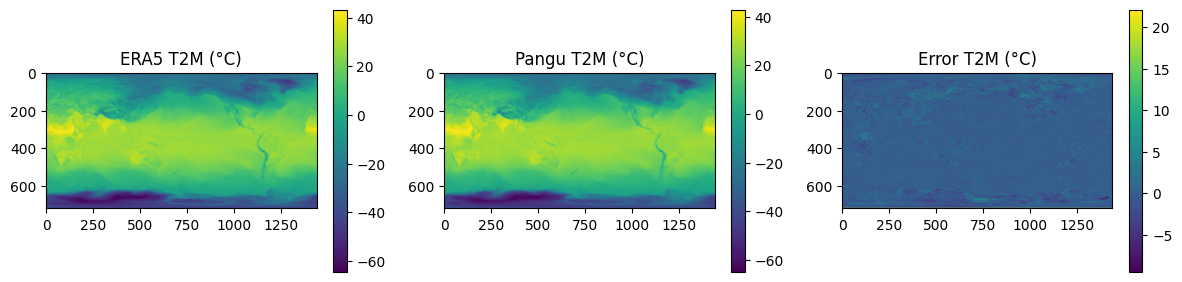

In [ ]:
# --- Celda 9.1: mapas T2M (°C) ---
import matplotlib.pyplot as plt

pred_t2m_C = pred_sfc[3] - 273.15
true_t2m_C = truth_t2m - 273.15
diff_t2m_C = pred_t2m_C - true_t2m_C

plt.figure(figsize=(12,3.8))
plt.subplot(1,3,1); plt.imshow(true_t2m_C, origin="upper"); plt.title("ERA5 T2M (°C)"); plt.colorbar(shrink=0.75)
plt.subplot(1,3,2); plt.imshow(pred_t2m_C, origin="upper"); plt.title("Pangu T2M (°C)"); plt.colorbar(shrink=0.75)
plt.subplot(1,3,3); plt.imshow(diff_t2m_C, origin="upper"); plt.title("Error T2M (°C)"); plt.colorbar(shrink=0.75)
plt.tight_layout(); plt.show()


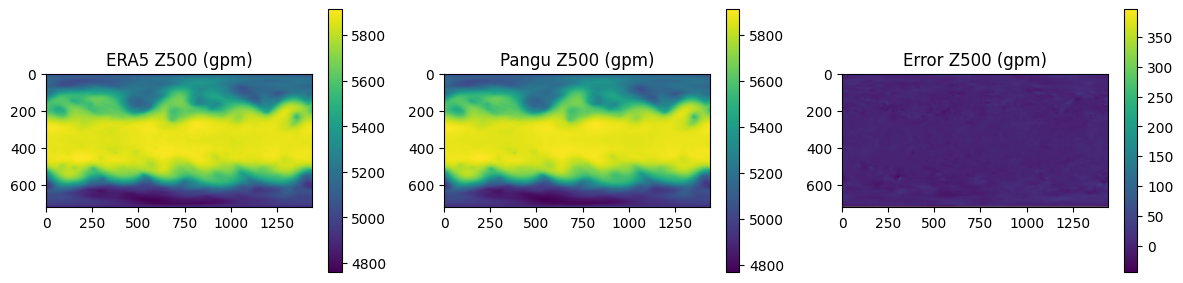

In [ ]:
# --- Celda 9.2: mapas Z500 (gpm) ---
g = 9.80665; idx500 = LEVELS_ORDER.index(500)
true_Z500_gpm = ds_pl_t1["z"].isel(time=0, **{lev_name: idx500}).values / g
pred_Z500_gpm = pred_up[0, idx500] / g
diff_Z500_gpm = pred_Z500_gpm - true_Z500_gpm

plt.figure(figsize=(12,3.8))
plt.subplot(1,3,1); plt.imshow(true_Z500_gpm, origin="upper"); plt.title("ERA5 Z500 (gpm)"); plt.colorbar(shrink=0.75)
plt.subplot(1,3,2); plt.imshow(pred_Z500_gpm, origin="upper"); plt.title("Pangu Z500 (gpm)"); plt.colorbar(shrink=0.75)
plt.subplot(1,3,3); plt.imshow(diff_Z500_gpm, origin="upper"); plt.title("Error Z500 (gpm)"); plt.colorbar(shrink=0.75)
plt.tight_layout(); plt.show()


🧹 10) Guardar outputs como NetCDF

In [ ]:
# --- Celda 10: exportar resultados a NetCDF (opcional) ---
ds_pred_sfc.to_netcdf("pangu_pred_surface_t1.nc")
ds_pred_up.to_netcdf("pangu_pred_upper_t1.nc")
print("Guardados: pangu_pred_surface_t1.nc, pangu_pred_upper_t1.nc")


Guardados: pangu_pred_surface_t1.nc, pangu_pred_upper_t1.nc


# Iteraciones continuas
Sabemos que los modelos son buenos para predecir el día siguiente (bueno para predicción de catastrofes si estamos en días cercanos a cuando el modelo fue entrenado)

- Los modelos climaticos tendran una vida media desde que fueron entrenados, desde entonces comenzarán a perder capacidades de predicción debido al cambio climatico. Por ello es necesario incorporar finetunning sobre estos para poder seguir utilizandolos.

- Los modelos se entrenan para predecir bien un día a otro, pero si hacemos un loop, de alimentarlo con sus predicciones, comenzaremos a observar un desgaste en las predicciones, queremos identificar cual es ese limite.

In [ ]:
# --- Celda A: helpers para verdad ERA5 y pesos latitud ---
from datetime import datetime, timedelta
import numpy as np
import xarray as xr
import os

def _era5_fnames(dt):
    """Convención de nombres coherente con tu notebook."""
    surf = f"era5_single_{dt:%Y%m%d_%H%M}.nc"
    pl   = f"era5_pl_{dt:%Y%m%d_%H%M}.nc"
    return surf, pl

def get_era5_truth(dt):
    """
    Asegura archivos de ERA5 para 'dt' y devuelve (ds_sfc, ds_pl) armonizados.
    Usa retrieve_if_missing(...) y repair_era5_file_inplace(...) ya definidas.
    """
    surf, pl = _era5_fnames(dt)

    # Descargar si faltan
    retrieve_if_missing("reanalysis-era5-single-levels",   _req_single(dt), surf)
    retrieve_if_missing("reanalysis-era5-pressure-levels", _req_pl(dt),     pl)

    # Reparar si hace falta
    _ = repair_era5_file_inplace(surf)
    _ = repair_era5_file_inplace(pl)

    # Cargar y armonizar
    ds_sfc, ds_pl = load_era5_for_pangu(surf, pl)

    # Nivel coord name para futuras selecciones por índice
    lev_name = "pressure_level" if "pressure_level" in ds_pl.coords else ("level" if "level" in ds_pl.coords else "pressure_level")
    return ds_sfc, ds_pl, lev_name

def lat_weights_from(ds_like):
    """Matriz de pesos cos(lat) para promedios globales con forma (lat, lon)."""
    lat = ds_like.latitude.values.astype("float32")
    return np.cos(np.deg2rad(lat))[:, None].astype("float32")


In [ ]:
# --- Celda B: inferencia única de Pangu con datasets en memoria ---
import numpy as np
import subprocess
import sys

def run_pangu_once(ds_sfc_in: xr.Dataset, ds_pl_in: xr.Dataset):
    """
    Toma ds_sfc/ds_pl (t en índice 0), escribe input_*.npy, llama al script de inferencia y
    retorna (ds_pred_sfc, ds_pred_up, pred_sfc_array, pred_up_array).
    NO borra 'output_data' para que puedas inspeccionar, pero sobreescribe si ya existen.
    """
    # 1) Guardar inputs npy con tu función existente
    make_pangu_inputs(ds_sfc_in, ds_pl_in,
                      out_surface="input_data/input_surface.npy",
                      out_upper="input_data/input_upper.npy")

    # 2) Ejecutar inferencia (GPU -> CPU fallback)
    try:
        subprocess.run([sys.executable, "inference_gpu.py"], check=True)
    except Exception:
        print("[WARN] GPU falló, probando CPU…")
        subprocess.run([sys.executable, "inference_cpu.py"], check=True)

    # 3) Cargar outputs .npy y envolver en xarray con tus coords/orden
    pred_sfc = np.load("output_data/output_surface.npy")   # (4, 721, 1440)
    pred_up  = np.load("output_data/output_upper.npy")     # (5, 13, 721, 1440)

    lat = ds_sfc_in.latitude.values.astype("float32")
    lon = ds_sfc_in.longitude.values.astype("float32")

    ds_pred_sfc = xr.Dataset(
        data_vars=dict(
            msl=(("latitude","longitude"), pred_sfc[0]),
            u10=(("latitude","longitude"), pred_sfc[1]),
            v10=(("latitude","longitude"), pred_sfc[2]),
            t2m=(("latitude","longitude"), pred_sfc[3]),
        ),
        coords=dict(latitude=lat, longitude=lon),
    )

    ds_pred_up = xr.Dataset(
        data_vars=dict(
            z=(("level","latitude","longitude"), pred_up[0]),
            q=(("level","latitude","longitude"), pred_up[1]),
            t=(("level","latitude","longitude"), pred_up[2]),
            u=(("level","latitude","longitude"), pred_up[3]),
            v=(("level","latitude","longitude"), pred_up[4]),
        ),
        coords=dict(level=LEVELS_ORDER, latitude=lat, longitude=lon),
    )

    return ds_pred_sfc, ds_pred_up, pred_sfc, pred_up


In [ ]:
# --- Celda C: cálculo de métricas por paso ---
def compute_step_metrics(pred_sfc_arr, pred_up_arr, truth_sfc: xr.Dataset, truth_pl: xr.Dataset, lev_name: str, W):
    """
    pred_*_arr son arrays crudos devueltos por Pangu:
      - surface: (4, 721, 1440) => [msl, u10, v10, t2m]
      - upper:   (5, 13, 721, 1440) => [z, q, t, u, v] con LEVELS_ORDER
    truth_* son datasets ERA5 armonizados a la misma malla.
    W son pesos latitudinales cos(lat)[:, None].
    Devuelve un dict con RMSE/MAE para T2M (K), MSLP (hPa) y Z500 (gpm).
    """
    # T2M (K)
    truth_t2m = truth_sfc["t2m"].isel(time=0).astype("float32").values
    rmse_t2m  = rmse(pred_sfc_arr[3], truth_t2m, W)
    mae_t2m   = mae(pred_sfc_arr[3], truth_t2m, W)

    # MSLP (hPa)
    truth_msl_hpa = truth_sfc["msl"].isel(time=0).astype("float32").values / 100.0
    rmse_msl = rmse(pred_sfc_arr[0] / 100.0, truth_msl_hpa, W)
    mae_msl  = mae(pred_sfc_arr[0] / 100.0, truth_msl_hpa, W)

    # Z500 (gpm)
    g = 9.80665
    idx500 = LEVELS_ORDER.index(500)
    # Por índice de nivel, acorde a tu pipeline:
    truth_z500_gpm = truth_pl["z"].isel(time=0, **{lev_name: idx500}).astype("float32").values / g
    pred_z500_gpm  = pred_up_arr[0, idx500] / g
    rmse_z500 = rmse(pred_z500_gpm, truth_z500_gpm, W)
    mae_z500  = mae(pred_z500_gpm, truth_z500_gpm, W)

    return {
        "rmse_t2m_K":  rmse_t2m,   "mae_t2m_K":  mae_t2m,
        "rmse_msl_hPa": rmse_msl,  "mae_msl_hPa": mae_msl,
        "rmse_z500_gpm": rmse_z500,"mae_z500_gpm": mae_z500,
    }


In [ ]:
# Celda: trazas y asserts de dims

import re
import numpy as np

def debug_dims(tag, ds_sfc, ds_pl):
    def dims_of(ds, keys):
        return {k: (tuple(ds[k].dims) if k in ds else None) for k in keys}
    print(f"[{tag}] SFC dims:", dims_of(ds_sfc, ["msl","u10","v10","t2m"]))
    print(f"[{tag}]  PL dims:", dims_of(ds_pl,  ["z","q","t","u","v"]))

def assert_time_present(ds_sfc, ds_pl):
    # Si existe, que esté en todas las vars principales
    for k in ["msl","u10","v10","t2m"]:
        if k in ds_sfc:
            assert ("time" in ds_sfc[k].dims) or (ds_sfc[k].ndim==2), f"{k} sin time y no 2D"
    for k in ["z","q","t","u","v"]:
        if k in ds_pl:
            assert ("time" in ds_pl[k].dims) or (ds_pl[k].ndim==3), f"{k} sin time y no 3D"


# estamapr el tiempo
# Celda: parseo de datetime desde nombre ERA5 y util para expandir time

from datetime import datetime

_nc_dt_re = re.compile(r"era5_(?:single|pl)_(\d{8})_(\d{4})\.nc$")

def dt_from_nc_name(fname: str) -> np.datetime64:
    m = _nc_dt_re.search(fname)
    if not m:
        raise ValueError(f"No pude parsear datetime desde {fname}")
    ymd, hm = m.groups()
    dt = datetime.strptime(ymd + hm, "%Y%m%d%H%M")
    return np.datetime64(dt)

def ensure_time_coord(ds_sfc, ds_pl, time_value):
    """Si no hay 'time', lo añade como dimensión de tamaño 1 con el valor entregado."""
    tv = np.array([np.datetime64(time_value)])
    if "time" not in ds_sfc.dims:
        ds_sfc = ds_sfc.expand_dims(time=tv)
    if "time" not in ds_pl.dims:
        ds_pl = ds_pl.expand_dims(time=tv)
    return ds_sfc, ds_pl


In [ ]:
# --- Celda D: rollout autoregresivo y comparación con ERA5 ---
def iterative_rollout(base_dt: datetime, n_steps: int = 30):
    """
    Ejecuta Pangu de forma autoregresiva N pasos de 24h:
      - Entrada del paso 0: ERA5 en base_dt
      - Paso k (1..N): predicción Pangu vs ERA5 en base_dt + 24*k h
      - Guarda métricas por paso, devuelve dict con arrays y metadatos
    """
    # 1) Verdad y pesos para t0
    ds_sfc_t0, ds_pl_t0, lev_name = get_era5_truth(base_dt)
    W = lat_weights_from(ds_sfc_t0)

    # 2) Estado actual de entrada (arranca desde verdad t0)
    ds_cur_sfc = ds_sfc_t0
    ds_cur_pl  = ds_pl_t0

    # 3) Acumuladores
    steps = []
    times = []
    metrics_list = []

    for k in range(1, n_steps+1):
        target_dt = base_dt + timedelta(hours=24*k)

        # --- Inferencia (usa ds_cur_* como entrada) ---
        ds_pred_sfc, ds_pred_up, pred_sfc_arr, pred_up_arr = run_pangu_once(ds_cur_sfc, ds_cur_pl)

        # --- Verdad ERA5 para el horizonte (t0 + 24*k) ---
        truth_sfc_k, truth_pl_k, lev_name_k = get_era5_truth(target_dt)

        # --- Métricas: calcular ANTES de reescribir inputs ---
        met = compute_step_metrics(pred_sfc_arr, pred_up_arr, truth_sfc_k, truth_pl_k, lev_name_k, W)
        metrics_list.append(met)
        steps.append(k)
        times.append(target_dt)

        # estamapr el tiempo para subsecuentes iteraciones
        ds_pred_sfc, ds_pred_up = ensure_time_coord(ds_pred_sfc, ds_pred_up, np.datetime64(target_dt))

        # # debugging
        # debug_dims(f"pred step {k}", ds_pred_sfc, ds_pred_up)    # ¿tienen 'time'?
        # debug_dims(f"next-in step {k+1}", ds_cur_sfc, ds_cur_pl) # lo que entra a make_pangu_inputs


        # --- Preparar inputs de la siguiente iteración con la predicción actual ---
        #     (esto sobreescribe input_data/input_*.npy)
        make_pangu_inputs(ds_pred_sfc, ds_pred_up,
                          out_surface="input_data/input_surface.npy",
                          out_upper="input_data/input_upper.npy")

        # --- Avanzar el estado autoregresivo ---
        ds_cur_sfc = ds_pred_sfc
        ds_cur_pl  = ds_pred_up

        print(f"[{base_dt:%Y-%m-%d %H:%M}] step {k:02d}/{n_steps} → {target_dt:%Y-%m-%d %H:%M} | "
              f"RMSE: T2M={met['rmse_t2m_K']:.3f}K, MSLP={met['rmse_msl_hPa']:.2f}hPa, Z500={met['rmse_z500_gpm']:.1f}gpm")

    # 4) Empaquetar resultados
    #    (conversión a arrays paralelos para análisis/plot posterior)
    out = {
        "base_dt": base_dt,
        "steps": np.array(steps, dtype=int),
        "times": np.array(times),
        "metrics": {
            key: np.array([m[key] for m in metrics_list], dtype=float)
            for key in metrics_list[0].keys()
        }
    }
    return out


Helpers para debugging

Ejecucion para un grupo de fechas

In [ ]:
# --- Celda E: ejecutar para múltiples fechas base ---
# Tomamos el día 15 a las 12:00 UTC de cada mes solicitado como referencia
# (puedes cambiarlo fácilmente si prefieres el día 01 o 00/12 UTC)
base_months = ["2022-06", "2024-12"]
base_datetimes = [datetime.strptime(m + "-15 12:00", "%Y-%m-%d %H:%M") for m in base_months]

results_per_base = {}
for bdt in base_datetimes:
    print(f"\n=== Base {bdt:%Y-%m-%d %H:%M} ===")
    results_per_base[bdt.strftime("%Y-%m-%d_%H%M")] = iterative_rollout(bdt, n_steps=5)

print("\nListo. Usa 'results_per_base' para analizar/plotear.")



=== Base 2022-06-15 12:00 ===
Descargando: era5_single_20220615_1200.nc


2025-10-21 15:39:39,443 INFO Request ID is 183a20ef-d043-4969-8737-ec3918afb397
INFO:ecmwf.datastores.legacy_client:Request ID is 183a20ef-d043-4969-8737-ec3918afb397
2025-10-21 15:39:39,666 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:39:53,942 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:40:01,756 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


2243e0a04ea31054c4c7cba7dd17d2a6.nc:   0%|          | 0.00/6.71M [00:00<?, ?B/s]

OK: era5_single_20220615_1200.nc
Descargando: era5_pl_20220615_1200.nc


2025-10-21 15:40:05,875 INFO Request ID is 68e65f23-8c2e-45cd-b659-b469808f2bc5
INFO:ecmwf.datastores.legacy_client:Request ID is 68e65f23-8c2e-45cd-b659-b469808f2bc5
2025-10-21 15:40:06,074 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:40:15,066 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:40:20,340 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


98263a2cc14270a7ab176e284e1bec6.nc:   0%|          | 0.00/118M [00:00<?, ?B/s]

OK: era5_pl_20220615_1200.nc
[repair] era5_single_20220615_1200.nc → netcdf4
[repair] era5_pl_20220615_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20220616_1200.nc


2025-10-21 15:41:10,565 INFO Request ID is ab4b6299-c657-4cbb-af90-9659db2defa8
INFO:ecmwf.datastores.legacy_client:Request ID is ab4b6299-c657-4cbb-af90-9659db2defa8
2025-10-21 15:41:10,806 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:41:25,109 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:41:32,932 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


6e979936281fd79eeb8e40ef8acff27e.nc:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

OK: era5_single_20220616_1200.nc
Descargando: era5_pl_20220616_1200.nc


2025-10-21 15:41:37,459 INFO Request ID is 16e735c4-f615-4bdf-b086-6579ef1ed12e
INFO:ecmwf.datastores.legacy_client:Request ID is 16e735c4-f615-4bdf-b086-6579ef1ed12e
2025-10-21 15:41:37,663 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:41:59,645 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


11be62a30fe543b30b221e430b9173f6.nc:   0%|          | 0.00/119M [00:00<?, ?B/s]

OK: era5_pl_20220616_1200.nc
[repair] era5_single_20220616_1200.nc → netcdf4
[repair] era5_pl_20220616_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2022-06-15 12:00] step 01/5 → 2022-06-16 12:00 | RMSE: T2M=0.708K, MSLP=0.62hPa, Z500=5.0gpm
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20220617_1200.nc


2025-10-21 15:42:45,055 INFO Request ID is 6ff7d176-8817-448d-8a21-db93db289e94
INFO:ecmwf.datastores.legacy_client:Request ID is 6ff7d176-8817-448d-8a21-db93db289e94
2025-10-21 15:42:45,279 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:42:59,612 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


1e3055752e816116a692f16e39e0b691.nc:   0%|          | 0.00/6.68M [00:00<?, ?B/s]

OK: era5_single_20220617_1200.nc
Descargando: era5_pl_20220617_1200.nc


2025-10-21 15:43:03,680 INFO Request ID is fe769958-fd95-4dd9-85b7-9869f5cfb13a
INFO:ecmwf.datastores.legacy_client:Request ID is fe769958-fd95-4dd9-85b7-9869f5cfb13a
2025-10-21 15:43:04,130 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:43:13,190 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:43:18,473 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:43:39,515 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


38d1822d489a1d13b99045599243da1b.nc:   0%|          | 0.00/120M [00:00<?, ?B/s]

OK: era5_pl_20220617_1200.nc
[repair] era5_single_20220617_1200.nc → netcdf4
[repair] era5_pl_20220617_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2022-06-15 12:00] step 02/5 → 2022-06-17 12:00 | RMSE: T2M=0.893K, MSLP=1.05hPa, Z500=9.9gpm
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20220618_1200.nc


2025-10-21 15:44:40,513 INFO Request ID is cec5d948-edd3-4133-827a-8739a83d8abb
INFO:ecmwf.datastores.legacy_client:Request ID is cec5d948-edd3-4133-827a-8739a83d8abb
2025-10-21 15:44:40,737 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:44:55,628 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


a09e2c80c1fbd75bcea4e302fb425704.nc:   0%|          | 0.00/6.72M [00:00<?, ?B/s]

OK: era5_single_20220618_1200.nc
Descargando: era5_pl_20220618_1200.nc


2025-10-21 15:44:59,902 INFO Request ID is 17f818ff-053d-477d-83c5-f53936d2ac55
INFO:ecmwf.datastores.legacy_client:Request ID is 17f818ff-053d-477d-83c5-f53936d2ac55
2025-10-21 15:45:00,164 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:45:14,697 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:45:22,652 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


cc7605efbccd4e45c5f38ae21c1c65cc.nc:   0%|          | 0.00/118M [00:00<?, ?B/s]

OK: era5_pl_20220618_1200.nc
[repair] era5_single_20220618_1200.nc → netcdf4
[repair] era5_pl_20220618_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2022-06-15 12:00] step 03/5 → 2022-06-18 12:00 | RMSE: T2M=1.030K, MSLP=1.55hPa, Z500=15.4gpm
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20220619_1200.nc


2025-10-21 15:46:08,520 INFO Request ID is 2d8c2274-cc92-4533-abc4-e10e8ce1f843
INFO:ecmwf.datastores.legacy_client:Request ID is 2d8c2274-cc92-4533-abc4-e10e8ce1f843
2025-10-21 15:46:08,770 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:46:23,145 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


44c2f61faec50f7a6e75a6bc2e12efc0.nc:   0%|          | 0.00/6.51M [00:00<?, ?B/s]

OK: era5_single_20220619_1200.nc
Descargando: era5_pl_20220619_1200.nc


2025-10-21 15:46:27,120 INFO Request ID is 9655303a-f29b-4163-9eb0-0351e7d7567e
INFO:ecmwf.datastores.legacy_client:Request ID is 9655303a-f29b-4163-9eb0-0351e7d7567e
2025-10-21 15:46:27,342 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:47:01,079 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


f7a59f3788633bbc1aeecbf398f76656.nc:   0%|          | 0.00/129M [00:00<?, ?B/s]

OK: era5_pl_20220619_1200.nc
[repair] era5_single_20220619_1200.nc → netcdf4
[repair] era5_pl_20220619_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2022-06-15 12:00] step 04/5 → 2022-06-19 12:00 | RMSE: T2M=1.342K, MSLP=2.48hPa, Z500=25.1gpm
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20220620_1200.nc


2025-10-21 15:47:47,703 INFO Request ID is 69645c65-b6cb-453d-98a8-6da9a4860cd2
INFO:ecmwf.datastores.legacy_client:Request ID is 69645c65-b6cb-453d-98a8-6da9a4860cd2
2025-10-21 15:47:47,954 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:47:56,966 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:48:02,259 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


992235d5b445123752c56d872fbb5dda.nc:   0%|          | 0.00/6.64M [00:00<?, ?B/s]

OK: era5_single_20220620_1200.nc
Descargando: era5_pl_20220620_1200.nc


2025-10-21 15:48:06,524 INFO Request ID is 650b3b19-2649-4079-abe4-e914e4d5c41c
INFO:ecmwf.datastores.legacy_client:Request ID is 650b3b19-2649-4079-abe4-e914e4d5c41c
2025-10-21 15:48:06,731 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:48:20,971 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:48:28,773 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


c7069a1b8105bf063ab9f2185a126ecc.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

OK: era5_pl_20220620_1200.nc
[repair] era5_single_20220620_1200.nc → netcdf4
[repair] era5_pl_20220620_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2022-06-15 12:00] step 05/5 → 2022-06-20 12:00 | RMSE: T2M=1.777K, MSLP=3.72hPa, Z500=38.0gpm

=== Base 2024-12-15 12:00 ===
Descargando: era5_single_20241215_1200.nc


2025-10-21 15:48:42,096 INFO Request ID is 13ac0476-3f0b-4468-82da-800ab8847b65
INFO:ecmwf.datastores.legacy_client:Request ID is 13ac0476-3f0b-4468-82da-800ab8847b65
2025-10-21 15:48:42,326 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:48:51,327 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:48:56,599 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


27b76bed8547e3f1257b2cb24eea41a0.nc:   0%|          | 0.00/6.68M [00:00<?, ?B/s]

OK: era5_single_20241215_1200.nc
Descargando: era5_pl_20241215_1200.nc


2025-10-21 15:49:00,561 INFO Request ID is f3b6f7f5-a93e-46b1-88ee-28a447e38f78
INFO:ecmwf.datastores.legacy_client:Request ID is f3b6f7f5-a93e-46b1-88ee-28a447e38f78
2025-10-21 15:49:01,374 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:49:10,397 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:49:15,910 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


cc9afa23a70f9733499e285840abe4c6.nc:   0%|          | 0.00/118M [00:00<?, ?B/s]

OK: era5_pl_20241215_1200.nc
[repair] era5_single_20241215_1200.nc → netcdf4
[repair] era5_pl_20241215_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20241216_1200.nc


2025-10-21 15:50:02,751 INFO Request ID is a8da40b4-bb10-41a7-919a-7b1ccd98b751
INFO:ecmwf.datastores.legacy_client:Request ID is a8da40b4-bb10-41a7-919a-7b1ccd98b751
2025-10-21 15:50:03,042 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:50:37,222 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


d5381813edf6c083149ce5fc0e7e6610.nc:   0%|          | 0.00/6.64M [00:00<?, ?B/s]

OK: era5_single_20241216_1200.nc
Descargando: era5_pl_20241216_1200.nc


2025-10-21 15:50:41,550 INFO Request ID is 35a01a80-810c-4aba-bd48-0f7827beba57
INFO:ecmwf.datastores.legacy_client:Request ID is 35a01a80-810c-4aba-bd48-0f7827beba57
2025-10-21 15:50:41,802 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:50:56,229 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:51:04,049 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


8a639a96a4d2fcfb6a4b2ba72f228b1d.nc:   0%|          | 0.00/115M [00:00<?, ?B/s]

8a639a96a4d2fcfb6a4b2ba72f228b1d.nc:   0%|          | 0.00/115M [00:00<?, ?B/s]

OK: era5_pl_20241216_1200.nc
[repair] era5_single_20241216_1200.nc → netcdf4
[repair] era5_pl_20241216_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2024-12-15 12:00] step 01/5 → 2024-12-16 12:00 | RMSE: T2M=0.769K, MSLP=0.64hPa, Z500=4.9gpm
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20241217_1200.nc


2025-10-21 15:54:52,065 INFO Request ID is c9716617-b547-4b30-9e6d-185c4ece9865
INFO:ecmwf.datastores.legacy_client:Request ID is c9716617-b547-4b30-9e6d-185c4ece9865
2025-10-21 15:54:52,321 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:55:06,737 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


c7eef245fc4de2dd6e443466ed7fa595.nc:   0%|          | 0.00/6.69M [00:00<?, ?B/s]

OK: era5_single_20241217_1200.nc
Descargando: era5_pl_20241217_1200.nc


2025-10-21 15:55:11,354 INFO Request ID is e0d14c1c-c3b8-447d-8c8c-39c4484a6f5d
INFO:ecmwf.datastores.legacy_client:Request ID is e0d14c1c-c3b8-447d-8c8c-39c4484a6f5d
2025-10-21 15:55:11,558 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:55:26,215 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:55:34,019 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


167cb650931f5653561f0dc6f1c3368a.nc:   0%|          | 0.00/118M [00:00<?, ?B/s]

OK: era5_pl_20241217_1200.nc
[repair] era5_single_20241217_1200.nc → netcdf4
[repair] era5_pl_20241217_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2024-12-15 12:00] step 02/5 → 2024-12-17 12:00 | RMSE: T2M=0.929K, MSLP=0.95hPa, Z500=8.1gpm
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20241218_1200.nc


2025-10-21 15:56:21,712 INFO Request ID is 687d873d-f44b-4037-8868-5913c74566bd
INFO:ecmwf.datastores.legacy_client:Request ID is 687d873d-f44b-4037-8868-5913c74566bd
2025-10-21 15:56:21,942 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:56:30,963 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:56:36,262 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


29b3fbba33ec82f8e074396314ea8fec.nc:   0%|          | 0.00/6.64M [00:00<?, ?B/s]

OK: era5_single_20241218_1200.nc
Descargando: era5_pl_20241218_1200.nc


2025-10-21 15:56:40,268 INFO Request ID is 2fe8b61e-d27d-45fe-a21a-8e6e1e800b6e
INFO:ecmwf.datastores.legacy_client:Request ID is 2fe8b61e-d27d-45fe-a21a-8e6e1e800b6e
2025-10-21 15:56:40,528 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:56:54,846 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


cfaae2dfeccb2caa7c68b072c1ea0c1f.nc:   0%|          | 0.00/119M [00:00<?, ?B/s]

OK: era5_pl_20241218_1200.nc
[repair] era5_single_20241218_1200.nc → netcdf4
[repair] era5_pl_20241218_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2024-12-15 12:00] step 03/5 → 2024-12-18 12:00 | RMSE: T2M=1.086K, MSLP=1.39hPa, Z500=13.8gpm
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20241219_1200.nc


2025-10-21 15:57:42,224 INFO Request ID is 917a6cc9-8899-4d77-8328-f67e2fda903b
INFO:ecmwf.datastores.legacy_client:Request ID is 917a6cc9-8899-4d77-8328-f67e2fda903b
2025-10-21 15:57:42,442 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:57:57,100 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


a14e02a30dd686223b96c6f2005e0352.nc:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

OK: era5_single_20241219_1200.nc
Descargando: era5_pl_20241219_1200.nc


2025-10-21 15:58:01,478 INFO Request ID is 0b901b29-dd70-4a5f-b9f9-fbca6bd949ca
INFO:ecmwf.datastores.legacy_client:Request ID is 0b901b29-dd70-4a5f-b9f9-fbca6bd949ca
2025-10-21 15:58:01,683 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:58:23,701 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b2c94855e6747bb440ef6f48a2af6b01.nc:   0%|          | 0.00/115M [00:00<?, ?B/s]

OK: era5_pl_20241219_1200.nc
[repair] era5_single_20241219_1200.nc → netcdf4
[repair] era5_pl_20241219_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2024-12-15 12:00] step 04/5 → 2024-12-19 12:00 | RMSE: T2M=1.325K, MSLP=2.05hPa, Z500=21.4gpm
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
Descargando: era5_single_20241220_1200.nc


2025-10-21 15:59:08,046 INFO Request ID is 709f7e40-9d0a-4b02-ae71-68293505ee22
INFO:ecmwf.datastores.legacy_client:Request ID is 709f7e40-9d0a-4b02-ae71-68293505ee22
2025-10-21 15:59:08,325 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:59:22,687 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 15:59:30,504 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


fc4fa3c966cff758aa4ca8ac6c3e0684.nc:   0%|          | 0.00/6.64M [00:00<?, ?B/s]

OK: era5_single_20241220_1200.nc
Descargando: era5_pl_20241220_1200.nc


2025-10-21 15:59:34,592 INFO Request ID is 07e4ce80-6a75-448d-b612-8b6fcb11ba8d
INFO:ecmwf.datastores.legacy_client:Request ID is 07e4ce80-6a75-448d-b612-8b6fcb11ba8d
2025-10-21 15:59:34,822 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 15:59:43,802 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ec42868b25188eee7f10773ee34403cf.nc:   0%|          | 0.00/111M [00:00<?, ?B/s]

OK: era5_pl_20241220_1200.nc
[repair] era5_single_20241220_1200.nc → netcdf4
[repair] era5_pl_20241220_1200.nc → netcdf4
[OK] Guardados: input_data/input_surface.npy | input_data/input_upper.npy
[2024-12-15 12:00] step 05/5 → 2024-12-20 12:00 | RMSE: T2M=1.582K, MSLP=2.98hPa, Z500=30.3gpm

Listo. Usa 'results_per_base' para analizar/plotear.


panel_df (primeras filas):


2022-06-15_1200                                                   \
          rmse_t2m_K mae_t2m_K rmse_msl_hPa mae_msl_hPa rmse_z500_gpm   
step                                                                    
1           0.707722  0.458559     0.624966    0.419236      4.996004   
2           0.893231  0.580098     1.046912    0.677484      9.894834   
3           1.029868  0.675003     1.552804    0.967179     15.383653   
4           1.342301  0.840955     2.479957    1.340622     25.055849   
5           1.776690  1.049567     3.718475    1.995109     38.024746   

                  2024-12-15_1200                                     \
     mae_z500_gpm      rmse_t2m_K mae_t2m_K rmse_msl_hPa mae_msl_hPa   
step                                                                   
1        3.515815        0.769069  0.472824     0.641152    0.460073   
2        6.226154        0.928782  0.578893     0.954396    0.678537   
3        9.328698        1.085784  0.667295     1.390417    0.915971   
4       14.133777        1.324825  0.803327     2.049397    1.306530   
5       21.251486        1.581763  0.955568     2.977816    1.886436   

                                 
     rmse_z500_gpm mae_z500_gpm  
step                             
1         4.920488     3.518028  
2         8.130051     5.468820  
3        13.822400     8.871019  
4        21.389585    12.895708  
5        30.289932    17.974022

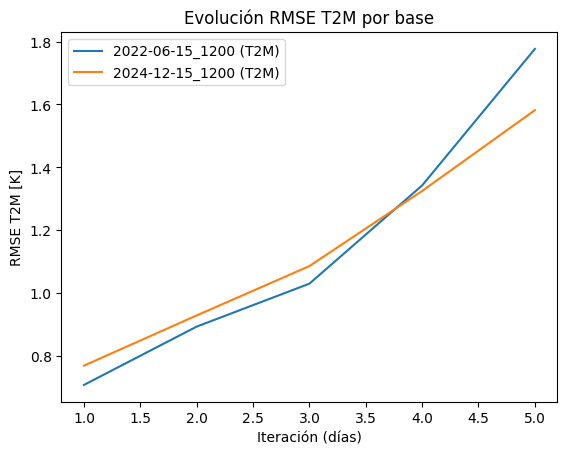

In [ ]:
# --- Celda F: tablas y vistazo rápido ---
import pandas as pd

# Construir un DataFrame por base_dt con columnas por métrica
dfs = {}
for key, res in results_per_base.items():
    df = pd.DataFrame({"step": res["steps"], "time": res["times"]})
    for mname, arr in res["metrics"].items():
        df[mname] = arr
    dfs[key] = df

# Ejemplo: concatenar con MultiIndex en columnas (base_dt / métrica)
panel = []
for key, df in dfs.items():
    df2 = df.set_index("step").drop(columns=["time"])
    df2.columns = pd.MultiIndex.from_product([[key], df2.columns])
    panel.append(df2)
panel_df = pd.concat(panel, axis=1)

print("panel_df (primeras filas):")
display(panel_df.head())

# Quick look: evolución de RMSE T2M por base
try:
    import matplotlib.pyplot as plt
    plt.figure()
    for key in dfs:
        plt.plot(dfs[key]["step"], dfs[key]["rmse_t2m_K"], label=f"{key} (T2M)")
    plt.xlabel("Iteración (días)")
    plt.ylabel("RMSE T2M [K]")
    plt.title("Evolución RMSE T2M por base")
    plt.legend()
    plt.show()
except Exception as e:
    print("Plot opcional no disponible:", e)


## 11) Animación de Predicción de Temperatura sobre Chile (objetivo y supuestos)

**Objetivo.** Generar material audiovisual (MP4/GIF) que muestre la evolución espacial de la **temperatura a 2 m (T2M)** predicha por el backend (Pangu-Weather), recortada a **Chile**, en dos modalidades:
1. **Temperatura absoluta** en °C.
2. **Índice visual** normalizado por percentiles (0–1) para realzar gradientes intra-región.

**Supuestos del pipeline vigente.**
- Las predicciones de superficie están en `ds_pred_sfc` y contienen `t2m` en Kelvin, con coordenadas globales `latitude` (90→−90) y `longitude` en **0..360**.
- (Opcional) La “verdad” (ERA5 en t₁ o rollout) está en `ds_truth_sfc`, con la misma malla y variable `t2m`.
- Si existe una dimensión temporal (p. ej., `time` o `step`), se animarán múltiples frames; si no, se producirá una animación con el único frame disponible.

**Región de Chile (lon en 0..360).**  
`lat ∈ [-56, -17]`, `lon ∈ [285, 294]` (equivale a −75…−66 en −180..180).

**Notas técnicas.**
- La **barra de color** indicará unidades: °C para temperatura; [0,1] para índice.
- Si `ds_truth_sfc` está disponible, el título mostrará el **RMSE areal ponderado** por cos(lat) por frame.
- Guardado por defecto a **MP4** con FFMpeg; si no está disponible, se cae a **GIF** (Pillow).

In [ ]:
# 11.A) Utilidades robustas para animaciones sobre Chile

from __future__ import annotations
import os
import io
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def _rename_std_coords(ds: xr.Dataset) -> xr.Dataset:
    """Renombra coords comunes a ('latitude','longitude') si viniesen como ('lat','lon')."""
    ren = {}
    if 'lat' in ds.coords and 'latitude' not in ds.coords:
        ren['lat'] = 'latitude'
    if 'lon' in ds.coords and 'longitude' not in ds.coords:
        ren['lon'] = 'longitude'
    if ren:
        ds = ds.rename(ren)
    return ds

def _to_lon_0_360(ds: xr.Dataset) -> xr.Dataset:
    """Convierte longitudes a [0,360) y reordena por longitude ascendente."""
    if 'longitude' not in ds.coords:
        raise ValueError("No se encuentra la coordenada 'longitude' en el dataset.")
    lon = ds['longitude']
    if np.nanmin(lon.values) < 0.0:
        ds = ds.assign_coords(longitude=(lon % 360))
        ds = ds.sortby('longitude')
    return ds

def _lat_slice(ds: xr.Dataset, lat_min: float, lat_max: float):
    """Devuelve un slice coherente con el orden de latitud del dataset."""
    lat = ds['latitude'].values
    if lat[0] > lat[-1]:
        # orden típico 90 -> -90
        return slice(lat_max, lat_min)
    else:
        return slice(lat_min, lat_max)

def _subset_bbox(ds: xr.Dataset, bbox: tuple[float, float, float, float]) -> xr.Dataset:
    """Recorta por caja (lat_min, lat_max, lon_min, lon_max) asumiendo longitudes en 0..360."""
    lat_min, lat_max, lon_min, lon_max = bbox
    ds = ds.sel(latitude=_lat_slice(ds, lat_min, lat_max))
    ds = ds.sel(longitude=ds.longitude.where(
        (ds.longitude >= lon_min) & (ds.longitude <= lon_max), drop=True))
    return ds

def _find_time_dim(da: xr.DataArray) -> str | None:
    """Intenta adivinar el nombre de la dimensión temporal."""
    for cand in ('time', 'step', 'forecast_time', 'valid_time', 'frame'):
        if cand in da.dims:
            return cand
    return None

def _kelvin_to_celsius(x: np.ndarray) -> np.ndarray:
    return x - 273.15

def _weights_coslat(lat_vals: np.ndarray) -> np.ndarray:
    """Pesos por cos(lat) normalizados a media 1 para promedio areal."""
    w = np.cos(np.deg2rad(lat_vals))
    w = np.clip(w, 0.0, None)
    m = np.nanmean(w)
    if m > 0:
        w = w / m
    return w

def _rmse_weighted(pred: np.ndarray, truth: np.ndarray, lat_vals: np.ndarray) -> float:
    """
    RMSE areal ponderado por cos(lat).
    pred/truth shape: (lat, lon) o (frames, lat, lon). Devuelve escalar si (lat,lon), o array[frames].
    """
    w = _weights_coslat(lat_vals)  # (lat,)
    if pred.ndim == 2:
        err2 = (pred - truth) ** 2  # (lat, lon)
        # promedio pesado sobre lat, luego promedio simple sobre lon
        num = np.nansum(err2 * w[:, None])
        den = np.nansum(np.isfinite(err2) * w[:, None])
        return math.sqrt(num / max(den, 1.0))
    elif pred.ndim == 3:
        # frames x lat x lon
        F = pred.shape[0]
        out = np.zeros(F, dtype=float)
        for i in range(F):
            out[i] = _rmse_weighted(pred[i], truth[i], lat_vals)
        return out
    else:
        raise ValueError("RMSE: se esperaban 2D o 3D (frames, lat, lon).")

def _pick_writer(out_path: str):
    """Elige writer disponible según sufijo del archivo."""
    want_mp4 = out_path.lower().endswith(".mp4")
    has_ffmpeg = animation.writers.is_available('ffmpeg')
    if want_mp4 and has_ffmpeg:
        return animation.FFMpegWriter(fps=6, bitrate=1800), 'ffmpeg/mp4'
    if want_mp4 and not has_ffmpeg:
        # caemos a GIF
        print("Aviso: ffmpeg no disponible. Se exportará GIF en su lugar.")
        out_path = out_path[:-4] + ".gif"
    # GIF con Pillow
    return animation.PillowWriter(fps=6), 'pillow/gif', out_path

In [ ]:
# 11.B) Función principal para construir la animación (temperatura o índice visual)

def make_chile_temperature_animation(
    ds_pred_sfc: xr.Dataset,
    ds_truth_sfc: xr.Dataset | None = None,
    var: str = "t2m",
    kind: str = "temperature",  # "temperature" | "index"
    bbox_chile: tuple[float, float, float, float] = (-56.0, -17.0, 285.0, 294.0),
    ensure_lon_mode_0_360: bool = True,
    fps: int = 6,
    dpi: int = 180,
    out_path: str = "chile_t2m_anim.mp4",
    cbar_label_override: str | None = None,
) -> tuple[str, np.ndarray]:
    """
    Construye una animación recortada a Chile. Devuelve (ruta_salida, preview_png_array).
    - kind="temperature": °C; autoscale por percentiles 5–95 de TODOS los frames del recorte.
    - kind="index": [0,1]; percentiles 5–95 por frame dentro del recorte (contraste local robusto).
    - Si ds_truth_sfc se pasa, el título incluye RMSE areal ponderado por cos(lat) por frame.
    """
    assert isinstance(ds_pred_sfc, xr.Dataset), "ds_pred_sfc debe ser xr.Dataset"
    if var not in ds_pred_sfc:
        raise KeyError(f"No se encontró la variable '{var}' en ds_pred_sfc.")

    # Normaliza coords y longitudes
    ds_pred = _rename_std_coords(ds_pred_sfc)
    if ensure_lon_mode_0_360:
        ds_pred = _to_lon_0_360(ds_pred)
    ds_pred = _subset_bbox(ds_pred, bbox_chile)

    # Verdad opcional
    ds_truth = None
    if ds_truth_sfc is not None and var in ds_truth_sfc:
        ds_truth = _rename_std_coords(ds_truth_sfc)
        if ensure_lon_mode_0_360:
            ds_truth = _to_lon_0_360(ds_truth)
        ds_truth = _subset_bbox(ds_truth, bbox_chile)

    # Extrae DataArray
    da_pred = ds_pred[var]
    time_dim = _find_time_dim(da_pred)
    has_time = time_dim is not None

    # Alinea temporalmente con la verdad si existe
    if ds_truth is not None:
        da_truth = ds_truth[var]
        if has_time and _find_time_dim(da_truth) == time_dim:
            da_pred, da_truth = xr.align(da_pred, da_truth, join='inner')
        else:
            # Sin dimensión temporal o no alineable: hace broadcast si es single-frame, si no, desactiva RMSE
            if _find_time_dim(da_truth) is None and has_time:
                da_truth = da_truth.expand_dims({time_dim: da_pred.sizes[time_dim]})
            elif has_time is False and _find_time_dim(da_truth) is not None:
                da_pred = da_pred.expand_dims({_find_time_dim(da_truth): da_truth.sizes[_find_time_dim(da_truth)]})
                time_dim = _find_time_dim(da_truth)
                has_time = True

    # Convierte a arrays (frames, lat, lon)
    lat_vals = da_pred['latitude'].values
    lon_vals = da_pred['longitude'].values

    if has_time:
        frames = da_pred.sizes[time_dim]
        pred_K = da_pred.transpose(time_dim, 'latitude', 'longitude').values  # (F, L, M)
        times = da_pred[time_dim].values
        if ds_truth is not None and var in ds_truth:
            truth_K = da_truth.transpose(time_dim, 'latitude', 'longitude').values
        else:
            truth_K = None
    else:
        pred_K = da_pred.values[None, ...]  # (1, L, M)
        frames = 1
        times = np.array([np.datetime64('NaT')], dtype='datetime64[ns]')
        if ds_truth is not None and var in ds_truth:
            truth_K = ds_truth[var].values[None, ...]
        else:
            truth_K = None

    # Prepara la matriz mostrada: temperatura en °C o índice [0,1]
    if kind == "temperature":
        data_show = _kelvin_to_celsius(pred_K.copy())   # (F, L, M)
        # límites globales robustos del recorte para paleta estable en la animación
        vmin = np.nanpercentile(data_show, 5.0)
        vmax = np.nanpercentile(data_show, 95.0)
        cbar_label = cbar_label_override or "T2m [°C]"
    elif kind == "index":
        data_show = np.zeros_like(pred_K, dtype=float)
        for i in range(frames):
            frame = pred_K[i]
            # imputación simple de NaN: percentil 5 del frame
            p5r = np.nanpercentile(frame, 5.0)
            frame = np.where(np.isfinite(frame), frame, p5r)
            # índice sobre K (equivalente a °C en diferencias)
            p5 = np.nanpercentile(frame, 5.0)
            p95 = np.nanpercentile(frame, 95.0)
            denom = max(p95 - p5, 1e-6)
            norm = (frame - p5) / denom
            data_show[i] = np.clip(norm, 0.0, 1.0)
        vmin, vmax = 0.0, 1.0
        cbar_label = cbar_label_override or "Índice de temperatura [0–1]"
    else:
        raise ValueError("kind debe ser 'temperature' o 'index'.")

    # RMSE por frame (en Kelvin); reportar en °C (equivalente)
    rmse_seq = None
    if truth_K is not None:
        try:
            rmse_seq = _rmse_weighted(pred_K, truth_K, lat_vals)
        except Exception as e:
            print("Aviso: no se pudo calcular RMSE ponderado:", e)
            rmse_seq = None

    # Figura / eje
    plt.close('all')
    fig = plt.figure(dpi=dpi)
    ax = fig.add_subplot(1,1,1)

    # extent=[x0,x1,y0,y1] → [lon_min, lon_max, lat_min, lat_max]
    extent = [lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()]

    img = ax.imshow(
        data_show[0], origin='upper', extent=extent, aspect='auto',
        vmin=vmin, vmax=vmax, interpolation='nearest'
    )
    cbar = fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(cbar_label)

    ax.set_xlabel("Longitud [°]")
    ax.set_ylabel("Latitud [°]")

    def _title_for_frame(i: int) -> str:
        ts = times[i] if i < len(times) else np.datetime64('NaT')
        ts_txt = str(np.datetime_as_string(ts, unit='m')) if str(ts) != 'NaT' else f"frame {i:02d}"
        if rmse_seq is not None:
            return f"{var.upper()} — Chile — {ts_txt} — RMSE={rmse_seq[i]:.2f} K"
        return f"{var.upper()} — Chile — {ts_txt}"

    ax.set_title(_title_for_frame(0))

    def _update(i):
        img.set_data(data_show[i])
        ax.set_title(_title_for_frame(i))
        return [img]

    anim = animation.FuncAnimation(
        fig, _update, frames=frames, interval=1000//max(fps,1), blit=True
    )

    # Selección de writer/salida
    out = out_path
    writer = None
    try:
        w = animation.writers['ffmpeg'] if out.lower().endswith('.mp4') else animation.writers['pillow']
        # Valida disponibilidad
        if out.lower().endswith('.mp4') and not animation.writers.is_available('ffmpeg'):
            print("Aviso: ffmpeg no disponible, exportando a GIF.")
            out = out[:-4] + ".gif"
            writer = animation.PillowWriter(fps=fps)
        else:
            writer = w(fps=fps)
    except Exception:
        # Fallback seguro a GIF
        out = out[:-4] + ".gif" if out.lower().endswith('.mp4') else out
        writer = animation.PillowWriter(fps=fps)

    # Guardado
    anim.save(out, writer=writer, dpi=dpi)
    print(f"Animación guardada en: {out}")

    # Preview (PNG) con el primer frame
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=dpi, bbox_inches='tight')
    buf.seek(0)
    import PIL.Image
    preview = np.array(PIL.Image.open(buf).convert("RGBA"))

    plt.close(fig)
    return out, preview

## 12) Ejemplo A: Temperatura absoluta (°C) con RMSE por frame

En este ejemplo animamos **T2M en °C** sobre Chile.  
Si `ds_truth_sfc` está disponible (ERA5 alineado), el **título incluirá RMSE areal ponderado** (cos(lat)) por frame, útil para comunicar desempeño cuantitativo junto al mensaje visual.

In [ ]:
# 12.A) Ejecutar animación en °C (usa RMSE si ds_truth_sfc está disponible)

# Verificaciones mínimas del entorno notebook
assert 'ds_pred_sfc' in globals(), "Se esperaba 'ds_pred_sfc' definido previamente en el notebook."
if 't2m' not in ds_pred_sfc:
    raise KeyError("El dataset de predicción no contiene la variable 't2m'.")

# (Opcional) verdad:
ds_truth_available = 'ds_truth_sfc' in globals() and isinstance(globals().get('ds_truth_sfc'), xr.Dataset) \
                     and ('t2m' in globals().get('ds_truth_sfc'))
if not ds_truth_available:
    print("Aviso: 'ds_truth_sfc' no está disponible o no contiene 't2m'. El título no incluirá RMSE.")

out_path_abs = "chile_t2m_abs.mp4"
out_abs, preview_abs = make_chile_temperature_animation(
    ds_pred_sfc=ds_pred_sfc,
    ds_truth_sfc=ds_truth_sfc if ds_truth_available else None,
    var="t2m",
    kind="temperature",
    bbox_chile=(-56.0, -17.0, 285.0, 294.0),
    ensure_lon_mode_0_360=True,
    fps=6,
    dpi=180,
    out_path=out_path_abs,
)
print("Archivo generado:", out_abs)
# Si estás en Colab, puedes descargarlo con:
# from google.colab import files; files.download(out_abs)

Aviso: 'ds_truth_sfc' no está disponible o no contiene 't2m'. El título no incluirá RMSE.
Animación guardada en: chile_t2m_abs.mp4
Archivo generado: chile_t2m_abs.mp4


## 13) Ejemplo B: Índice visual [0,1] (contraste local robusto)

Este modo normaliza por frame usando los **percentiles 5–95** dentro de Chile, limitando la influencia de outliers.  
Es apropiado para **video explicativo** cuando interesa resaltar gradientes y patrones relativos, más que valores absolutos.

In [ ]:
# 13.A) Ejecutar animación de índice visual (0–1)

out_path_idx = "chile_t2m_index.mp4"
out_idx, preview_idx = make_chile_temperature_animation(
    ds_pred_sfc=ds_pred_sfc,
    ds_truth_sfc=None,  # índice es relativo; si se desea, puede mantenerse None
    var="t2m",
    kind="index",
    bbox_chile=(-56.0, -17.0, 285.0, 294.0),
    ensure_lon_mode_0_360=True,
    fps=6,
    dpi=180,
    out_path=out_path_idx,
)
print("Archivo generado:", out_idx)

Animación guardada en: chile_t2m_index.mp4
Archivo generado: chile_t2m_index.mp4


## 14) Notas para la presentación (guion breve)

- **Contexto del backend:** Pangu-Weather se integra solo en la etapa de predicción de T2M; el resto del pipeline (ERA5, preparación de tensores, post-procesado) está estandarizado.
- **Recorte espacial:** Chile con longitudes en 0..360 (285–294). Este convenio evita discontinuidades alrededor de 0°/360°.
- **Dos narrativas visuales:**
  - °C absolutos (rango estable por percentiles 5–95 de todos los frames del recorte).
  - Índice [0,1] por frame (contraste local robusto para resaltar patrones).
- **Métrica en título:** RMSE areal **ponderado por cos(lat)**; comunica desempeño cuantitativo por frame, útil en rollouts autoregresivos.
- **Decisiones de robustez:** imputación mínima de `NaN` (percentil 5 por frame), y límites por percentiles que estabilizan la paleta ante outliers.
- **Exportación:** Preferimos MP4 con FFMpeg (fluidez y compatibilidad); si no está instalado, el código cae a GIF.

In [ ]:
# 15.A) Guardar portada del primer frame en °C para el video

import matplotlib.pyplot as plt

def save_static_cover_png(preview_rgba: np.ndarray, out_png: str = "chile_t2m_cover.png"):
    plt.figure(dpi=200)
    plt.imshow(preview_rgba)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_png, dpi=200, bbox_inches='tight')
    plt.close()
    print(f"Portada guardada en: {out_png}")

# Usa la previsualización generada en 12.A
if 'preview_abs' in globals():
    save_static_cover_png(preview_abs, "chile_t2m_cover.png")
else:
    print("No se encontró 'preview_abs'. Ejecuta primero la celda 12.A.")

Portada guardada en: chile_t2m_cover.png


In [ ]:
# 16.A) Preparación/recuperación ERA5 para un T0 (single levels + pressure levels)
import os, pathlib, datetime as dt
import numpy as np
import xarray as xr

def _ensure_dir(p):
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)

# Configuración de variables ERA5
SL_VARS = ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "mean_sea_level_pressure"]
PL_VARS = ["geopotential", "specific_humidity", "temperature", "u_component_of_wind", "v_component_of_wind"]
PL_LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]  # 13 niveles

def _download_era5_single_level(t0: dt.datetime, out_nc: str):
    import cdsapi
    c = cdsapi.Client()
    year, month, day, hour = f"{t0:%Y}", f"{t0:%m}", f"{t0:%d}", f"{t0:%H}"
    req = {
        "product_type": "reanalysis",
        "format": "netcdf",
        "variable": SL_VARS,
        "year": year,
        "month": month,
        "day": day,
        "time": hour,
    }
    c.retrieve("reanalysis-era5-single-levels", req, out_nc)

def _download_era5_pressure_level(t0: dt.datetime, out_nc: str):
    import cdsapi
    c = cdsapi.Client()
    year, month, day, hour = f"{t0:%Y}", f"{t0:%m}", f"{t0:%d}", f"{t0:%H}"
    req = {
        "product_type": "reanalysis",
        "format": "netcdf",
        "variable": PL_VARS,
        "pressure_level": [str(x) for x in PL_LEVELS],
        "year": year,
        "month": month,
        "day": day,
        "time": hour,
    }
    c.retrieve("reanalysis-era5-pressure-levels", req, out_nc)

def _harmonize_coords(ds: xr.Dataset) -> xr.Dataset:
    # Nombres estandard
    ren = {}
    if 'lat' in ds.coords and 'latitude' not in ds.coords: ren['lat'] = 'latitude'
    if 'lon' in ds.coords and 'longitude' not in ds.coords: ren['lon'] = 'longitude'
    if ren: ds = ds.rename(ren)
    # Longitud 0..360 y orden
    if ds.longitude.min() < 0:
        ds = ds.assign_coords(longitude=(ds.longitude % 360)).sortby('longitude')
    # Orden lat (90 -> -90) si fuese necesario no cambiamos; el pipeline soporta ambos usando slice apropiado
    return ds

def prepare_inputs_for_t0(
    t0: dt.datetime,
    cache_dir: str = "era5_cache"
) -> tuple[xr.Dataset, xr.Dataset]:
    """
    Devuelve (ds_cur_sfc@t0, ds_cur_pl@t0). Si no existen en caché, los descarga.
    """
    _ensure_dir(cache_dir)
    fn_sfc = os.path.join(cache_dir, f"era5_single_{t0:%Y%m%d_%H}Z.nc")
    fn_pl  = os.path.join(cache_dir, f"era5_press_{t0:%Y%m%d_%H}Z.nc")

    if not os.path.exists(fn_sfc):
        print(f"[ERA5] Descargando single levels: {t0} → {fn_sfc}")
        _download_era5_single_level(t0, fn_sfc)
    if not os.path.exists(fn_pl):
        print(f"[ERA5] Descargando pressure levels: {t0} → {fn_pl}")
        _download_era5_pressure_level(t0, fn_pl)

    ds_sfc = xr.open_dataset(fn_sfc)
    ds_pl  = xr.open_dataset(fn_pl)

    # Print variable names for debugging
    print(f"[DEBUG] Variables in {fn_sfc}: {list(ds_sfc.variables)}")
    print(f"[DEBUG] Variables in {fn_pl}: {list(ds_pl.variables)}")


    # Estándar de nombres/coords usado en el pipeline
    ds_sfc = _harmonize_coords(ds_sfc)
    ds_pl  = _harmonize_coords(ds_pl)

    # The variable names are already in the shorter format, so no renaming is needed here.
    # ds_sfc = ds_sfc.rename({
    #     "2m_temperature": "t2m",
    #     "10m_u_component_of_wind": "u10",
    #     "10m_v_component_of_wind": "v10",
    #     "mean_sea_level_pressure": "msl",
    # })

    # ds_pl = ds_pl.rename({
    #     "geopotential": "z",
    #     "specific_humidity": "q",
    #     "temperature": "t",
    #     "u_component_of_wind": "u",
    #     "v_component_of_wind": "v",
    # })

    # Remueve dimensión time si es de longitud 1 y deja 2D/3D limpias (el runner puede esperar time-less):
    if "time" in ds_sfc.dims and ds_sfc.sizes["time"] == 1:
        ds_sfc = ds_sfc.isel(time=0, drop=True)
    if "time" in ds_pl.dims and ds_pl.sizes["time"] == 1:
        ds_pl = ds_pl.isel(time=0, drop=True)

    return ds_sfc, ds_pl

def prepare_truth_for_t0_plus_24h(
    t0: dt.datetime,
    cache_dir: str = "era5_cache"
) -> xr.Dataset:
    """
    Devuelve ERA5 single levels a t1 = t0 + 24h (solo t2m es necesario para RMSE en las animaciones).
    """
    t1 = t0 + dt.timedelta(hours=24)
    fn_sfc_t1 = os.path.join(cache_dir, f"era5_single_{t1:%Y%m%d_%H}Z.nc")
    if not os.path.exists(fn_sfc_t1):
        print(f"[ERA5] Descargando single levels (t1): {t1} → {fn_sfc_t1}")
        _download_era5_single_level(t1, fn_sfc_t1)
    ds_truth = xr.open_dataset(fn_sfc_t1)
    ds_truth = _harmonize_coords(ds_truth) # .rename({
    #     "2m_temperature": "t2m",
    #     "10m_u_component_of_wind": "u10",
    #     "10m_v_component_of_wind": "v10",
    #     "mean_sea_level_pressure": "msl",
    # })
    if "time" in ds_truth.dims and ds_truth.sizes["time"] == 1:
        ds_truth = ds_truth.isel(time=0, drop=True)
    return ds_truth

In [ ]:
# 16.B) Corre la inferencia para varios T0 y concatena en una secuencia temporal ('valid_time')
import pandas as pd

def run_pangu_over_bases(
    base_times: list[dt.datetime],
    cache_dir: str = "era5_cache"
) -> tuple[xr.Dataset, xr.Dataset | None]:
    """
    Para cada T0 en base_times:
      1) Prepara ERA5 t0 (superficie + niveles).
      2) Ejecuta run_pangu_once(ds_cur_sfc, ds_cur_pl).
      3) Añade coord 'valid_time' = T0 + 24h y concatena a lo largo de esa dimensión.

    Devuelve:
      ds_pred_sfc_seq: Dataset con dimensión 'valid_time' y variables de superficie (incluye 't2m').
      ds_truth_sfc_seq: (opcional) Secuencia ERA5 single-levels en t0+24h, alineada por 'valid_time'.
    """
    pred_sfc_list = []
    truth_sfc_list = []

    for t0 in base_times:
        # --- Entradas ERA5 en t0 ---
        ds_cur_sfc, ds_cur_pl = prepare_inputs_for_t0(t0, cache_dir=cache_dir)

        # --- Pangu (un paso +24h) ---
        ds_pred_sfc, ds_pred_up, pred_sfc_arr, pred_up_arr = run_pangu_once(ds_cur_sfc, ds_cur_pl)

        # Asegura nombres/coords coherentes y añade 'valid_time'
        vt = np.array([t0 + dt.timedelta(hours=24)], dtype="datetime64[ns]")
        ds_pred_sfc = ds_pred_sfc.expand_dims(valid_time=vt)

        pred_sfc_list.append(ds_pred_sfc)

        # --- Verdad opcional (ERA5 en t1) para RMSE ---
        try:
            ds_truth = prepare_truth_for_t0_plus_24h(t0, cache_dir=cache_dir)
            ds_truth = ds_truth[["t2m", "msl", "u10", "v10"]].expand_dims(valid_time=vt)
            truth_sfc_list.append(ds_truth)
        except Exception as e:
            print(f"[WARN] No se pudo obtener verdad para {t0}: {e}")

    # Concatena secuencias
    ds_pred_sfc_seq = xr.concat(pred_sfc_list, dim="valid_time").sortby("valid_time")
    ds_truth_sfc_seq = xr.concat(truth_sfc_list, dim="valid_time").sortby("valid_time") if truth_sfc_list else None

    # Normaliza longitudes a 0..360 por si algún bloque difiere
    if ds_pred_sfc_seq.longitude.min() < 0:
        ds_pred_sfc_seq = ds_pred_sfc_seq.assign_coords(longitude=(ds_pred_sfc_seq.longitude % 360)).sortby("longitude")
    if ds_truth_sfc_seq is not None and ds_truth_sfc_seq.longitude.min() < 0:
        ds_truth_sfc_seq = ds_truth_sfc_seq.assign_coords(longitude=(ds_truth_sfc_seq.longitude % 360)).sortby("longitude")

    return ds_pred_sfc_seq, ds_truth_sfc_seq

In [ ]:
# 17.A) Corre Pangu en varios T0 y genera animaciones para Chile

# --- Configura el barrido temporal ---
START   = dt.datetime(2025, 9, 1, 12)  # ejemplo
N_STEPS = 20                              # nº de T0
FREQ_H  = 24                             # separación entre T0, en horas

base_times = [START + dt.timedelta(hours=i*FREQ_H) for i in range(N_STEPS)]
print("Base times (T0):", base_times)

# --- Ejecuta Pangu y construye secuencias ---
ds_pred_sfc_seq, ds_truth_sfc_seq = run_pangu_over_bases(base_times, cache_dir="era5_cache")

# Renombra dim temporal de predicción a un nombre reconocido por la animación
ds_pred_for_anim = ds_pred_sfc_seq.rename({"valid_time": "time"})
ds_truth_for_anim = ds_truth_sfc_seq.rename({"valid_time": "time"}) if ds_truth_sfc_seq is not None else None

# --- Animación en °C con RMSE por frame (si hay verdad) ---
out_abs, preview_abs = make_chile_temperature_animation(
    ds_pred_sfc=ds_pred_for_anim,
    ds_truth_sfc=ds_truth_for_anim,
    var="t2m",
    kind="temperature",
    bbox_chile=(-56.0, -17.0, 285.0, 294.0),
    ensure_lon_mode_0_360=True,
    fps=6,
    dpi=180,
    out_path="chile_t2m_abs_seq.mp4",
)
print("Animación (°C):", out_abs)

# --- Animación de índice [0,1] (contraste local por frame) ---
out_idx, preview_idx = make_chile_temperature_animation(
    ds_pred_sfc=ds_pred_for_anim,
    ds_truth_sfc=None,
    var="t2m",
    kind="index",
    bbox_chile=(-56.0, -17.0, 285.0, 294.0),
    ensure_lon_mode_0_360=True,
    fps=6,
    dpi=180,
    out_path="chile_t2m_index_seq.mp4",
)
print("Animación (índice):", out_idx)

Base times (T0): [datetime.datetime(2025, 9, 1, 12, 0), datetime.datetime(2025, 9, 2, 12, 0), datetime.datetime(2025, 9, 3, 12, 0), datetime.datetime(2025, 9, 4, 12, 0), datetime.datetime(2025, 9, 5, 12, 0), datetime.datetime(2025, 9, 6, 12, 0), datetime.datetime(2025, 9, 7, 12, 0), datetime.datetime(2025, 9, 8, 12, 0), datetime.datetime(2025, 9, 9, 12, 0), datetime.datetime(2025, 9, 10, 12, 0), datetime.datetime(2025, 9, 11, 12, 0), datetime.datetime(2025, 9, 12, 12, 0), datetime.datetime(2025, 9, 13, 12, 0), datetime.datetime(2025, 9, 14, 12, 0), datetime.datetime(2025, 9, 15, 12, 0), datetime.datetime(2025, 9, 16, 12, 0), datetime.datetime(2025, 9, 17, 12, 0), datetime.datetime(2025, 9, 18, 12, 0), datetime.datetime(2025, 9, 19, 12, 0), datetime.datetime(2025, 9, 20, 12, 0)]
[ERA5] Descargando single levels: 2025-09-01 12:00:00 → era5_cache/era5_single_20250901_12Z.nc


2025-10-21 15:59:57,963 INFO Request ID is 86568fbe-cccb-4c68-a548-5c0f585c775a
INFO:ecmwf.datastores.legacy_client:Request ID is 86568fbe-cccb-4c68-a548-5c0f585c775a
2025-10-21 15:59:58,189 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-21 16:00:12,432 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-21 16:00:20,250 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


edab95611127c1e2d56b2cb393a15712.nc:   0%|          | 0.00/6.63M [00:00<?, ?B/s]

[ERA5] Descargando pressure levels: 2025-09-01 12:00:00 → era5_cache/era5_press_20250901_12Z.nc


2025-10-21 16:00:35,619 INFO Request ID is 04ab5b5d-5e6a-4c44-98cd-2d0f993224d5
INFO:ecmwf.datastores.legacy_client:Request ID is 04ab5b5d-5e6a-4c44-98cd-2d0f993224d5
2025-10-21 16:00:35,867 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted


# Standarize Index

In [ ]:
# === Descarga ERA5 mensual T2M para Chile (1991–2025-10) con cdsapi, y preparación del NetCDF final ===
import os, pathlib
import numpy as np
import xarray as xr
import pandas as pd # Import pandas

# 0) Dependencia
try:
    import cdsapi  # noqa
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "cdsapi"])
    import cdsapi  # noqa

# 1) Parámetros y rutas
CACHE_DIR = "tmp"
OUT_ALL   = os.path.join(CACHE_DIR, "ERA5_T2M_monthly_1991_2025_chile.nc")
TMP_1991_2024 = os.path.join(CACHE_DIR, "ERA5_T2M_monthly_1991_2024_chile.nc")
TMP_2025_01_10 = os.path.join(CACHE_DIR, "ERA5_T2M_monthly_2025_01_10_chile.nc")

pathlib.Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)

# 2) Parámetros de área (Chile) y utilidades
AREA_CHILE = [-17, -76, -56, -66]  # [N, W, S, E] en grados, longitudes en −180..180

def cds_retrieve_monthly_t2m_years(outfile: str, years: list[str], months: list[str]):
    """
    Descarga ERA5 monthly means (T2M) con cdsapi para el dominio de Chile y guarda en 'outfile'.
    """
    if os.path.exists(outfile):
        print(f"[SKIP] Ya existe: {outfile}")
        return

    c = cdsapi.Client()
    req = {
        "product_type": "monthly_averaged_reanalysis",
        "format": "netcdf",
        "variable": ["2m_temperature"],
        "year": years,
        "month": months,
        "time": "00:00",
        "area": AREA_CHILE,  # [North, West, South, East] con longitudes −180..180
    }
    print(f"[CDS] Solicitando {len(years)} años × {len(months)} meses → {outfile}")
    c.retrieve("reanalysis-era5-single-levels-monthly-means", req, outfile)
    print(f"[OK] Guardado: {outfile}")

# 3) Descargas por tramos (maneja disponibilidad de 2025 hasta octubre)
years_1991_2024 = [str(y) for y in range(1991, 2025)]
months_full = [f"{m:02d}" for m in range(1, 13)]
cds_retrieve_monthly_t2m_years(TMP_1991_2024, years_1991_2024, months_full)

years_2025 = ["2025"]
months_2025_jan_oct = [f"{m:02d}" for m in range(1, 11)]  # Ene–Oct 2025
try:
    cds_retrieve_monthly_t2m_years(TMP_2025_01_10, years_2025, months_2025_jan_oct)
except Exception as e:
    print("[WARN] No se pudo descargar 2025 Ene–Oct. ¿Disponibilidad parcial en CDS? ->", e)
    # Si falla, continuamos con 1991–2024 solamente.
    TMP_2025_01_10 = None

# 4) Unir resultados y normalizar coordenadas
def _normalize_coords(ds: xr.Dataset) -> xr.Dataset:
    ren = {}
    if 'lat' in ds.coords and 'latitude' not in ds.coords: ren['lat'] = 'latitude'
    if 'lon' in ds.coords and 'longitude' not in ds.coords: ren['lon'] = 'longitude'
    if ren:
        ds = ds.rename(ren)
    # ERA5 mensual viene con longitudes en −180..180 -> conviértelas a 0..360 si se desea coherencia global
    if float(ds.longitude.min()) < 0.0:
        ds = ds.assign_coords(longitude=(ds.longitude % 360)).sortby('longitude')
    return ds

datasets = []
ds_1991_2024 = xr.open_dataset(TMP_1991_2024)
datasets.append(_normalize_coords(ds_1991_2024))

if TMP_2025_01_10 is not None and os.path.exists(TMP_2025_01_10):
    ds_2025 = xr.open_dataset(TMP_2025_01_10)
    datasets.append(_normalize_coords(ds_2025))

# Concatena sobre 'time' and ensure 'time' is datetime64
ds_all = xr.concat(datasets, dim="time").sortby("time")
# Explicitly set the time coordinate as a DatetimeIndex with monthly frequency
ds_all['time'] = pd.to_datetime(ds_all.time.values).to_period('M').to_timestamp()


# Asegura nombre corto 't2m'
if "2m_temperature" in ds_all:
    ds_all = ds_all.rename({"2m_temperature": "t2m"})

# Persistencia
comp = dict(zlib=True, complevel=4)
encoding = {var: comp for var in ds_all.data_vars}
ds_all.to_netcdf(OUT_ALL, encoding=encoding)
print(f"[OK] Ensamblado final: {OUT_ALL}  |  tiempo: {ds_all.time.min().values} → {ds_all.time.max().values}")

# Carga final en memoria para el resto del flujo
era5_t2m_monthly = xr.open_dataset(OUT_ALL, decode_times=True)
era5_t2m_monthly

In [ ]:
import xarray as xr, numpy as np, os

ds = era5_t2m_monthly

# 0) Nombre de variable y limpieza de coords/dims problemáticas
if "2m_temperature" in ds and "t2m" not in ds:
    ds = ds.rename({"2m_temperature": "t2m"})

# 'expver' llega como coord con dims (time, valid_time): bórrala para evitar alineaciones raras
ds = ds.reset_coords(names=["expver"], drop=True)

# Si existe la dim 'time' (dummy en mensuales), elimínala
if "time" in ds.dims:
    # toma el primer índice o colapsa; aquí eliminamos la dim
    ds = ds.isel(time=0, drop=True)

# Ahora t2m debe ser (valid_time, latitude, longitude)
da = ds["t2m"].sortby("valid_time")

# 1) Recorte 1991–2020 sobre valid_time
da_base = da.sel(valid_time=slice("1991-01-01", "2020-12-31"))

# 2) Climatología mensual por valid_time
clim_mean = da_base.groupby("valid_time.month").mean("valid_time", keep_attrs=True).reset_coords(drop=True)
clim_std  = da_base.groupby("valid_time.month").std( "valid_time", keep_attrs=True).reset_coords(drop=True)

# 3) Seguridad numérica
clim_std = xr.where(clim_std < 1e-6, 1e-6, clim_std)

# 4) Dataset final (sin coords “colgantes”)
clim = xr.Dataset({"t2m_mean": clim_mean, "t2m_std": clim_std})

# 5) Guardado
CLIM_PATH = os.path.join(CACHE_DIR, "ERA5_T2M_climatology_1991_2020_chile.nc")
comp = dict(zlib=True, complevel=4)
clim.to_netcdf(CLIM_PATH, encoding={k: comp for k in clim.data_vars})
print(f"[OK] Climatología guardada en: {CLIM_PATH} | months: {clim.sizes.get('month')}")
clim

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# --- Parámetros Chile con longitudes en 0..360 ---
BBOX_CHILE = (-56.0, -17.0, 285.0, 294.0)  # (lat_min, lat_max, lon_min, lon_max)

def _to_lon_0_360(ds: xr.Dataset) -> xr.Dataset:
    if float(ds.longitude.min()) < 0.0:
        ds = ds.assign_coords(longitude=(ds.longitude % 360)).sortby('longitude')
    return ds

def _lat_slice(ds: xr.Dataset, lat_min: float, lat_max: float):
    lat = ds['latitude'].values
    if lat[0] > lat[-1]:
        return slice(lat_max, lat_min)  # 90 -> -90
    else:
        return slice(lat_min, lat_max)

def subset_chile(da: xr.DataArray, bbox=BBOX_CHILE) -> xr.DataArray:
    lat_min, lat_max, lon_min, lon_max = bbox
    ds = da.to_dataset(name="var")
    ds = _to_lon_0_360(ds)
    ds = ds.sel(latitude=_lat_slice(ds, lat_min, lat_max))
    ds = ds.sel(longitude=ds.longitude.where(
        (ds.longitude >= lon_min) & (ds.longitude <= lon_max), drop=True))
    return ds["var"]

def compute_sti_from_clim(
    ds_pred: xr.Dataset,
    clim: xr.Dataset,
    var: str = "t2m",
    time_dim: str = "valid_time"
) -> xr.DataArray:
    """
    STI(time, lat, lon) = (t2m - mu_month) / sigma_month
    - ds_pred: t2m[K] con dimensión temporal 'valid_time'
    - clim: datasets con t2m_mean, t2m_std indexados por 'month' (1..12)
    """
    assert var in ds_pred, f"'{var}' no está en ds_pred."
    da = ds_pred[var]
    if time_dim not in da.dims:
        raise ValueError(f"Dimensión temporal esperada '{time_dim}' no encontrada en {da.dims}")
    months = xr.DataArray(da[time_dim].dt.month, coords={time_dim: da[time_dim]}, dims=[time_dim])
    mu = clim["t2m_mean"].sel(month=months)
    sig = xr.where(clim["t2m_std"].sel(month=months) < 1e-6, 1e-6, clim["t2m_std"].sel(month=months))
    sti = (da - mu) / sig
    sti.name = "sti"
    return sti

def animate_field_chile(
    da: xr.DataArray,
    time_dim: str = "valid_time",
    out_path: str = "sti_chile.mp4",
    vlim: float = 3.0,
    fps: int = 6,
    dpi: int = 180
) -> str:
    """
    Anima un campo (time, lat, lon) recortado a Chile. Paleta simétrica [-vlim, vlim].
    """
    # Orden y shapes
    da = da.transpose(time_dim, "latitude", "longitude")
    lat = da["latitude"].values
    lon = da["longitude"].values
    times = da[time_dim].values
    data = da.values  # (F, L, M)

    # Figura
    plt.close('all')
    fig, ax = plt.subplots(dpi=dpi)
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]

    img = ax.imshow(data[0], origin='upper', extent=extent,
                    vmin=-vlim, vmax=vlim, interpolation='nearest', aspect='auto')
    cbar = fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("STI [z-score]")

    ax.set_xlabel("Longitud [°]")
    ax.set_ylabel("Latitud [°]")

    def ttl(i):
        try:
            ts = np.datetime_as_string(times[i], unit='D')
        except Exception:
            ts = f"frame {i}"
        return f"STI — Chile — {ts}"

    ax.set_title(ttl(0))

    def update(i):
        img.set_data(data[i])
        ax.set_title(ttl(i))
        return [img]

    # Writer
    if out_path.lower().endswith('.mp4') and animation.writers.is_available('ffmpeg'):
        writer = animation.FFMpegWriter(fps=fps)
    else:
        if out_path.lower().endswith('.mp4'):
            print("Aviso: ffmpeg no disponible; exportando GIF.")
            out_path = out_path[:-4] + ".gif"
        writer = animation.PillowWriter(fps=fps)

    ani = animation.FuncAnimation(fig, update, frames=data.shape[0], interval=1000//fps, blit=True)
    ani.save(out_path, writer=writer, dpi=dpi)
    plt.close(fig)
    print("Animación guardada:", out_path)
    return out_path

In [ ]:
# Asume que existen:
# - ds_pred_sfc_seq: Dataset con t2m[K], dims (valid_time, latitude, longitude)
# - clim: Dataset con t2m_mean, t2m_std por 'month' (1..12) en el mismo dominio espacial

# 1) STI desde la predicción (usando valid_time)
sti = compute_sti_from_clim(ds_pred_sfc_seq, clim, var="t2m", time_dim="valid_time")

# 2) Recorte a Chile (lon 0..360: 285–294; lat −56…−17)
sti_chile = subset_chile(sti, bbox=BBOX_CHILE)

# 3) Animación
out_file = animate_field_chile(sti_chile, time_dim="valid_time",
                               out_path="sti_chile.mp4", vlim=3.0, fps=6, dpi=180)
out_file